# **Age Trends Among Olympic Athletes**
## by David Kobilnyk
---

# Table of Contents

<ul>
    <li><a href="#Introduction">Introduction</a></li>
    <li><a href="#Gathering">Gathering</a></li>
    <li><a href="#Cleaning">Cleaning</a></li>
    <ul>
        <li><a href="#Quality">Quality</a></li>
        <ul>
            <li><a href="#Clarity">Clarity</a></li>
            <li><a href="#Completeness">Completeness</a></li>
            <li><a href="#Validity">Validity</a></li>
            <li><a href="#Accuracy">Accuracy</a></li>
            <li><a href="#Consistency">Consistency</a></li>
            <li><a href="#Usefulness">Usefulness</a></li>
            <li><a href="#Simplicity">Simplicity</a></li>
        </ul>
        <li><a href="#Tidiness">Tidiness</a></li>
        <li><a href="#Cleaning-Recap">Cleaning Recap</a></li>
    </ul>
    <li><a href="#Feature-Engineering">Feature Engineering</a></li>
    <li><a href="#Exploring">Exploring</a></li>
    <ul>
        <li><a href="#Univariate">Univariate</a></li>
        <li><a href="#Bivariate">Bivariate</a></li>
        <li><a href="#Multivariate">Multivariate</a></li>
    </ul>
</ul>


# Introduction

A friend of mine and I are fans of figure skating in the Winter Olympics. She made an observation that the ages and career lengths of competitive figure skaters have been decreasing over time, as the competition has gotten more fierce in recent years. I am curious to see how true the observation is within Olympic figure skating in particular, and within Olympic sports more generally. To this end, I found a data set on Kaggle that seems to be just what I need to figure this out: https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results/home.

The investigation will mostly focus on the ages of the athletes over time, and we will also look at many other variables to see if they help shed light on the age trends.

## Software installation versions
* python: 3.6.7
* numpy: 1.14.2
* scipy: 1.0.0
* scikit-learn: 0.19.1
* pandas: 0.23.4
* statsmodels: 0.9.0
* matplotlib: 3.0.2
* seaborn: 0.9.0

## Initial Setup

In [1]:
# Standard library
import itertools
import math
import random
import time

# Data science tools
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 30)

# Gathering

[<a href="#Table-of-Contents">Back to Table of Contents</a>]

We will gather two data sources:
1. athlete_events.csv, the primary source, which contains an entry for each competing entrant in each olympic event throughout olympic history, and
2. noc_regions.csv, a secondary source that we'll use for replacing the NOC codes in athlete_events.csv with the names of the countries they stand for.

In [2]:
df_athlete_events = pd.read_csv('athlete_events.csv')
df_athlete_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
ID        271116 non-null int64
Name      271116 non-null object
Sex       271116 non-null object
Age       261642 non-null float64
Height    210945 non-null float64
Weight    208241 non-null float64
Team      271116 non-null object
NOC       271116 non-null object
Games     271116 non-null object
Year      271116 non-null int64
Season    271116 non-null object
City      271116 non-null object
Sport     271116 non-null object
Event     271116 non-null object
Medal     39783 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [3]:
df_noc = pd.read_csv('noc_regions.csv')
df_noc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
NOC       230 non-null object
region    227 non-null object
notes     21 non-null object
dtypes: object(3)
memory usage: 5.5+ KB


For convenience, throughout the notebook, we will often use the terms *df_athlete_events* and *df_noc* to refer to our most current versions of these data frames, even if the actual variable name contains a suffix such as `_complete` (e.g., `df_athlete_events_complete`).

# Cleaning

## Quality

### Clarity
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In this section, we will look for ways to improve the clarity of the data set for our use.

At the beginning of each section involving changes to the dataframes, we will create copies to use for our further modification, so that we still have the older version intact.

In [4]:
# Keep previous versions of data frames intact.
df_athlete_events_clear = df_athlete_events.copy()
df_noc_clear = df_noc.copy()

We won't be keeping all of the columns in `df_athlete_events`, since many of the columns wouldn't likely have any interesting connection with age. Before we remove any of them, we will use some of them to check for data consistency with columns we do intend to keep. For now, let's place the columns we intend to remove at the end of the column list.

In [5]:
# Define: Reorder the columns of df_athlete_events so that
#  the following columns come at the end of the table:
#  'Name', 'NOC', 'Height', 'Weight', 'Team', 'Games', 'City'.

# Clean.
cols_to_keep = ['ID', 'Sex', 'Age', 'Year', 'Season', 'Sport', 'Event', 'Medal']
cols_to_remove = ['Name', 'NOC', 'Height', 'Weight', 'Team', 'Games', 'City']
column_order = cols_to_keep + cols_to_remove
df_athlete_events_clear = df_athlete_events_clear[column_order]

# Test.
df_athlete_events_clear.head(3)

,ID,Sex,Age,Year,Season,Sport,Event,Medal,Name,NOC,Height,Weight,Team,Games,City
0,1,M,24.0,1992,Summer,Basketball,Basketball Men's Basketball,NaN,A Dijiang,CHN,180.0,80.0,China,1992 Summer,Barcelona
1,2,M,23.0,2012,Summer,Judo,Judo Men's Extra-Lightweight,NaN,A Lamusi,CHN,170.0,60.0,China,2012 Summer,London
2,3,M,24.0,1920,Summer,Football,Football Men's Football,NaN,Gunnar Nielsen Aaby,DEN,NaN,NaN,Denmark,1920 Summer,Antwerpen


The `ID` column holds an athlete ID, according to https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results/home. Let's rename the `ID` column to be clear that the ID is not an event ID or athlete/event combination ID or something else.

In [6]:
# Define: Rename the ID column of df_athlete_events to AthleteID.

# Clean.
df_athlete_events_clear.rename(columns={'ID': 'AthleteID'}, inplace=True)

# Test.
df_athlete_events_clear.head(1)

,AthleteID,Sex,Age,Year,Season,Sport,Event,Medal,Name,NOC,Height,Weight,Team,Games,City
0,1,M,24.0,1992,Summer,Basketball,Basketball Men's Basketball,NaN,A Dijiang,CHN,180.0,80.0,China,1992 Summer,Barcelona


In `df_noc`, the column name `region` seems a little vague. Let's see if we can make it more specific.

In [7]:
np.array(df_noc_clear.region.head(25).tolist())

array(['Afghanistan', 'Curacao', 'Albania', 'Algeria', 'Andorra',
       'Angola', 'Antigua', 'Australia', 'Argentina', 'Armenia', 'Aruba',
       'American Samoa', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bangladesh', 'Barbados', 'Burundi', 'Belgium', 'Benin', 'Bermuda',
       'Bhutan', 'Bosnia and Herzegovina', 'Belize'], dtype='<U22')

These all appear to be countries. Let's rename the column to `Country` (capitalized to be consistent with the column capitalization in `df_athlete_events`, where the column will eventually end up).

In [8]:
# Define: Rename the column 'region' to 'Country', in df_noc.

# Clean.
df_noc_clear.rename(columns={'region': 'Country'}, inplace=True)

# Test.
df_noc_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
NOC        230 non-null object
Country    227 non-null object
notes      21 non-null object
dtypes: object(3)
memory usage: 5.5+ KB


### Completeness
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In [9]:
# Keep previous versions of data frames intact.
df_athlete_events_complete = df_athlete_events_clear.copy()
df_noc_complete = df_noc_clear.copy()

Let's look for null values in `df_athlete_events`.

In [10]:
df_athlete_events_complete.isnull().sum()

AthleteID         0
Sex               0
Age            9474
Year              0
Season            0
Sport             0
Event             0
Medal        231333
Name              0
NOC               0
Height        60171
Weight        62875
Team              0
Games             0
City              0
dtype: int64

There are four columns with null values:
1. `Age` -- since age is central to our project, we will remove any rows with a null `Age` value.
2. `Medal` -- the nulls in this column are fine since a null `Medal` value just means that the particular athlete did not win any medal for the given event, but let's update these nulls to the string `None` for charting convenience later.
3. `Height` -- we don't care about this column and can just remove it.
4. `Weight` -- we don't care about this column either and can just remove it.

Let's investigate these null `Age` rows a little bit before we remove them. First, we'll examine the percent of rows with a null `Age` throughout history, to see if there are any time periods in particular that we may end up missing a lot of data for.

In [11]:
df_null_age = df_athlete_events_complete[df_athlete_events_complete.Age.isna()]
n_null_ages_by_year = df_null_age.Year.value_counts().sort_index()
n_entries_by_year = df_athlete_events_complete.groupby('Year').AthleteID.count()
(n_null_ages_by_year / n_entries_by_year).dropna()

1896    0.428947
1900    0.408058
1904    0.210607
1906    0.428736
1908    0.209287
1912    0.038614
1920    0.196878
1924    0.200597
1928    0.172766
1932    0.099368
1936    0.028780
1948    0.157219
1952    0.029600
1956    0.099161
1960    0.023931
1964    0.005907
1968    0.011261
1972    0.008027
1976    0.004951
1980    0.020924
1984    0.018640
1988    0.007495
1992    0.002681
1994    0.000633
1996    0.000581
1998    0.000555
2000    0.000072
2008    0.000147
dtype: float64

Some of the early Olympiads have a very high rate of missing ages. We'll need to be mindful of this during our exploration later. Fortunately, the rate of missing ages has decreased greatly over the years. Let's check if missing ages show up more frequently for particular values of a few other variables. For example, are there any sports in particular which have high rates of missing ages?

In [12]:
n_null_age_by_sport = df_null_age.Sport.value_counts()
n_entries_by_sport = df_athlete_events_complete.Sport.value_counts()
(n_null_age_by_sport / n_entries_by_sport).sort_values(ascending=False).head(20)

Lacrosse               0.400000
Alpinism               0.360000
Rugby                  0.296296
Tug-Of-War             0.258824
Cricket                0.250000
Roque                  0.250000
Croquet                0.210526
Military Ski Patrol    0.208333
Art Competitions       0.141699
Motorboating           0.117647
Shooting               0.071716
Wrestling              0.068633
Fencing                0.066605
Cycling                0.062437
Football               0.055597
Polo                   0.052632
Boxing                 0.052588
Weightlifting          0.052324
Water Polo             0.052002
Rowing                 0.049646
Name: Sport, dtype: float64

Indeed, Lacrosse and Alpinism in particular are hit hard here. How about `Sex`?

In [13]:
n_null_age_by_sex = df_null_age.Sex.value_counts()
n_entries_by_sex = df_athlete_events_complete.Sex.value_counts()
(n_null_age_by_sex / n_entries_by_sex).sort_values(ascending=False)

M    0.046034
F    0.005690
Name: Sex, dtype: float64

A much higher percent of male entries are lacking an age than female entries. But in both cases, the percentages are rather small. How about NOCs?

In [14]:
n_null_age_by_noc = df_null_age.NOC.value_counts()
n_entries_by_noc = df_athlete_events_complete.NOC.value_counts()
(n_null_age_by_noc / n_entries_by_noc).sort_values(ascending=False).head(20)

UNK    1.000000
CRT    1.000000
UAR    0.544715
MAL    0.511111
LBA    0.500000
SUD    0.448598
NIG    0.404255
AFG    0.380952
GUI    0.328767
IRQ    0.318966
GRE    0.305250
BOH    0.274510
NEP    0.265957
UAE    0.243056
MAR    0.209677
VNM    0.193548
BEN    0.183099
LIB    0.176292
CGO    0.171429
BEL    0.163080
Name: NOC, dtype: float64

Indeed, some NOCs have very high rates of missing ages. We will completely lose UNK and CRT from our exploration.

Now that we are a little bit more aware of what types of rows we will be losing, let's go ahead and remove the rows with a null Age.

In [15]:
# Define: Remove all rows having a null Age.

# Clean.
age_not_null = df_athlete_events_complete.Age.notnull()
df_athlete_events_complete = df_athlete_events_complete[age_not_null].copy()

# Test.
df_athlete_events_complete.Age.isnull().sum() == 0

True

Next, let's change the `Medal` column as planned.

In [16]:
# Define: Replace np.NaN in Medal with the string 'None'.

# Clean.
df_athlete_events_complete['Medal'] = (
    df_athlete_events_complete['Medal'].replace(np.NaN, 'None')
)

# Test.
(
    df_athlete_events_complete.Medal.isnull().sum() == 0,
    df_athlete_events_complete.Medal.unique().tolist()
)

(True, ['None', 'Gold', 'Bronze', 'Silver'])

And finally, we'll remove the `Height` and `Weight` columns.

In [17]:
# Define: Remove the Height and Weight columns.

# Clean.
df_athlete_events_complete.drop(['Height', 'Weight'], axis=1, inplace=True)

# Test.
df_athlete_events_complete.isnull().sum()

AthleteID    0
Sex          0
Age          0
Year         0
Season       0
Sport        0
Event        0
Medal        0
Name         0
NOC          0
Team         0
Games        0
City         0
dtype: int64

Now, let's move on to `df_noc` -- any null values?

In [18]:
df_noc_complete.isnull().sum()

NOC          0
Country      3
notes      209
dtype: int64

We have nulls in both `Country` and `notes`. In the case of `notes`, it seems entirely reasonable that at least some entries of a column so named would be null. As for `Country`, let's take a look.

In [19]:
df_noc_complete[df_noc_complete.Country.isnull()]

,NOC,Country,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


Ah well, it seems that using the `notes` values in these cases would be a good idea. We won't need UNK since all its ages are missing anyway, but ROT and TUV have some non-null age values.

In [20]:
# Define: Replace all null Country entries with the corresponding notes entry.

# Clean.
df_noc_null_countries = df_noc_complete[df_noc_complete.Country.isnull()].copy()
df_noc_complete.loc[df_noc_null_countries.index, 'Country'] = (
    df_noc_null_countries.notes)

# Test.
new_countries = df_noc_complete.loc[df_noc_null_countries.index, 'Country']
replacement_notes = df_noc_complete.loc[df_noc_null_countries.index, 'notes']
notes_filled_nulls = (new_countries == replacement_notes).all()
print(notes_filled_nulls)

df_noc_country_notnull = df_noc_clear.Country.notnull()
nonnull_countries = df_noc_clear[df_noc_country_notnull].Country
nonnull_countries_cleaned = df_noc_complete[df_noc_country_notnull].Country
nonnull_countries_unaffected = (
    nonnull_countries == nonnull_countries_cleaned
).all()
print(nonnull_countries_unaffected)

True
True


Recall that the only reason for `df_noc` is to replace the `NOC` column in `df_athlete_events` with the `Country` column. Let's see if `df_noc` can replace all of the NOC values for us.

In [21]:
noc_from_df_athlete_events = set(df_athlete_events_complete.NOC.unique())
noc_from_df_noc = set(df_noc_complete.NOC.unique())
noc_missing_from_df_noc = noc_from_df_athlete_events.difference(noc_from_df_noc)
noc_missing_from_df_noc

{'SGP'}

We can see from https://www.olympic.org/singapore that SGP is a code for Singapore. Let's add it in.

In [22]:
# Define: Add an entry in df_noc for Singapore (SGP).

# Clean.
df_noc_complete = df_noc_complete.append(
    {'NOC': 'SGP', 'Country': 'Singapore'}, ignore_index=True)

# Test.
df_noc_complete[df_noc_complete.NOC == 'SGP']

,NOC,Country,notes
230,SGP,Singapore,NaN


It should be safe now to merge these two data frames later in our Tidiness section.

### Validity
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In [23]:
# Keep previous versions of data frames intact.
df_athlete_events_valid = df_athlete_events_complete.copy()
df_noc_valid = df_noc_complete.copy()

Let's check for any discrepancies between `AthleteID` and `Name` (i.e., cases where a given `AthleteID` is associated with multiple names). One way to do this is to compare the number of unique `AthleteID`s against the number of unique `AthleteID`-`Name` pairs. These two numbers should be equal.

In [24]:
# Does each ID always have exactly one Name associated with it?
n_athlete_ids = df_athlete_events_valid.AthleteID.nunique()
n_athlete_id_name_pairs = len(
    df_athlete_events_valid.groupby(['AthleteID', 'Name']).count())
n_athlete_ids == n_athlete_id_name_pairs

True

All good. 

Let's check the unique values of `Sex`, `Season`, `Sport`, and `Medal` for anything that appears invalid.

In [25]:
df_athlete_events_valid.Sex.unique()

array(['M', 'F'], dtype=object)

In [26]:
df_athlete_events_valid.Season.unique()

array(['Summer', 'Winter'], dtype=object)

In [27]:
df_athlete_events_valid.Sport.unique()

array(['Basketball', 'Judo', 'Football', 'Tug-Of-War', 'Speed Skating',
       'Cross Country Skiing', 'Athletics', 'Ice Hockey', 'Swimming',
       'Badminton', 'Sailing', 'Biathlon', 'Gymnastics',
       'Art Competitions', 'Alpine Skiing', 'Handball', 'Weightlifting',
       'Wrestling', 'Luge', 'Water Polo', 'Hockey', 'Rowing', 'Bobsleigh',
       'Fencing', 'Equestrianism', 'Shooting', 'Boxing', 'Taekwondo',
       'Cycling', 'Diving', 'Canoeing', 'Tennis', 'Modern Pentathlon',
       'Figure Skating', 'Golf', 'Softball', 'Archery', 'Volleyball',
       'Synchronized Swimming', 'Table Tennis', 'Nordic Combined',
       'Baseball', 'Rhythmic Gymnastics', 'Freestyle Skiing',
       'Rugby Sevens', 'Trampolining', 'Beach Volleyball', 'Triathlon',
       'Ski Jumping', 'Curling', 'Snowboarding', 'Rugby',
       'Short Track Speed Skating', 'Skeleton', 'Lacrosse', 'Polo',
       'Cricket', 'Racquets', 'Military Ski Patrol', 'Croquet',
       'Jeu De Paume', 'Roque', 'Alpinism', 'Motorb

In [28]:
df_athlete_events_valid.Medal.unique()

array(['None', 'Gold', 'Bronze', 'Silver'], dtype=object)

All of these values appear to be valid.

Let's check the range of values for each numeric column.

In [29]:
df_athlete_events_valid.describe()

,AthleteID,Age,Year
count,261642.000000,261642.000000,261642.000000
mean,68291.263960,25.556898,1980.100221
std,38997.527135,6.393561,28.629035
min,1.000000,10.000000,1896.000000
25%,34755.250000,21.000000,1964.000000
50%,68198.000000,24.000000,1988.000000
75%,102108.750000,28.000000,2004.000000
max,135571.000000,97.000000,2016.000000


These are all valid values for these columns. A max age of 97 is surprising though. We will investigate this issue next in the Accuracy section.

### Accuracy
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In [30]:
# Keep previous version of data frame intact.
df_athlete_events_accurate = df_athlete_events_valid.copy()
df_noc_accurate = df_noc_valid.copy()

Let's check out which sports anyone 65 or older participated in.

In [31]:
df_athlete_events_accurate[df_athlete_events_accurate.Age >= 65].Sport.unique()

array(['Art Competitions', 'Shooting', 'Equestrianism', 'Archery',
       'Sailing'], dtype=object)

None of these activities should require extreme athleticism, as we'd expect.

`Sex` is repeated for any athlete who competes more than once. Let's check if any athlete is listed with more than one sex identity. Such an occurrence could result from an error, or in modern times, from a sex transition.

In [32]:
# Does Sex ever change for any athlete?
n_unique_athletes = df_athlete_events_accurate.AthleteID.nunique()
n_unique_athlete_sexes = len(
    df_athlete_events_accurate.groupby(['AthleteID', 'Sex']).count())
n_unique_athletes != n_unique_athlete_sexes

False

No, there is only one `Sex` identity for each athlete.

Each `Year` & `Season` combination should match the corresponding `Games` value.

In [33]:
games = df_athlete_events_accurate.Games
years = df_athlete_events_accurate.Year.astype(str)
seasons = df_athlete_events_accurate.Season
n_differences = (games != years + ' ' + seasons).sum()
no_differences = (n_differences == 0)
no_differences

True

Good. Let's see if there are any `Sports` in common between `Winter` and `Summer`; that would be suspect.

In [34]:
is_summer = df_athlete_events_accurate.Season == 'Summer'
df_summer = df_athlete_events_accurate[is_summer].copy()
df_winter = df_athlete_events_accurate[~is_summer].copy()
summer_sports = set(df_summer.Sport.unique())
winter_sports = set(df_winter.Sport.unique())
sports_in_common = summer_sports.intersection(winter_sports)
sports_in_common

{'Alpinism', 'Figure Skating', 'Ice Hockey'}

Alpinism would seem to be a summer sport, and we know that Figure Skating and Ice Hockey occur during the Winter Olympics. Let's see what years Alpinism was part of the Winter Olympics, and what years the other two sports were part of the Summer Olympics.

In [35]:
df_winter[df_winter.Sport == 'Alpinism'].Year.sort_values().unique()

array([1924])

In [36]:
df_summer[df_summer.Sport.isin(['Figure Skating', 'Ice Hockey'])].Year.unique()

array([1920, 1908])

A couple quick web searches confirm the accuracy of these values. Thus, no action is required. Here are some sources:
* https://www.sports-reference.com/olympics/winter/1924/ALP/
* https://en.wikipedia.org/wiki/Figure_skating_at_the_1920_Summer_Olympics
* https://en.wikipedia.org/wiki/Figure_skating_at_the_1908_Summer_Olympics

Values for the following fields should all be the same, given any particular combination of `AthleteID` and `Games`:
> `Age`, `NOC`, and `City`.

Let's verify that.

In [37]:
n_athlete_seasons = len(
    df_athlete_events_accurate.groupby(['AthleteID', 'Games']).count())
n_athlete_season_breakdowns = len(
    df_athlete_events_accurate
    .groupby(['AthleteID', 'Games', 'Age', 'NOC', 'City'])
    .count()
)
n_athlete_seasons == n_athlete_season_breakdowns

True

As expected.

### Consistency
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In [38]:
# Keep previous versions of data frames intact.
df_athlete_events_consistent = df_athlete_events_accurate.copy()
df_noc_consistent = df_noc_accurate.copy()

Let's make sure all of the non-null `NOC` values are exactly three characters long.

In [39]:
(df_athlete_events_consistent.NOC.apply(len) == 3).all()

True

Indeed.

### Usefulness
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In [40]:
# Keep previous versions of data frames intact.
df_athlete_events_useful = df_athlete_events_consistent.copy()
df_noc_useful = df_noc_consistent.copy()

Let us proceed to drop the unnecessary columns remaining in df_athlete_events and df_noc.

In [41]:
# Define: Drop unnecessary columns from df_athlete_events:
#  'Name', 'Team', 'Games', 'City'.

# Clean.
columns_to_drop = ['Name', 'Team', 'Games', 'City']
df_athlete_events_useful.drop(columns_to_drop, axis=1, inplace=True)

# Test.
df_athlete_events_useful.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261642 entries, 0 to 271115
Data columns (total 9 columns):
AthleteID    261642 non-null int64
Sex          261642 non-null object
Age          261642 non-null float64
Year         261642 non-null int64
Season       261642 non-null object
Sport        261642 non-null object
Event        261642 non-null object
Medal        261642 non-null object
NOC          261642 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 20.0+ MB


Let's check if we care about any more of the values in the `notes` column in `df_noc`.

In [42]:
df_noc_useful[df_noc_useful.notes.notnull()]

,NOC,Country,notes
1,AHO,Curacao,Netherlands Antilles
6,ANT,Antigua,Antigua and Barbuda
7,ANZ,Australia,Australasia
26,BOH,Czech Republic,Bohemia
51,CRT,Greece,Crete
88,HKG,China,Hong Kong
93,IOA,Individual Olympic Athletes,Individual Olympic Athletes
99,ISV,"Virgin Islands, US",Virgin Islands
143,NBO,Malaysia,North Borneo
147,NFL,Canada,Newfoundland


Actually, it might be a good idea to use `Hong Kong` instead of `China` for `HKG`.

In [43]:
# Define: Update Country associated with HKG to Hong Kong.

# Clean.
hkg_index = df_noc_useful[df_noc_useful.NOC == 'HKG'].index
df_noc_useful.loc[hkg_index, 'Country'] = 'Hong Kong'

# Test.
df_noc_useful[df_noc_useful.notes.notnull()][:10]

,NOC,Country,notes
1,AHO,Curacao,Netherlands Antilles
6,ANT,Antigua,Antigua and Barbuda
7,ANZ,Australia,Australasia
26,BOH,Czech Republic,Bohemia
51,CRT,Greece,Crete
88,HKG,Hong Kong,Hong Kong
93,IOA,Individual Olympic Athletes,Individual Olympic Athletes
99,ISV,"Virgin Islands, US",Virgin Islands
143,NBO,Malaysia,North Borneo
147,NFL,Canada,Newfoundland


Now we can remove the `notes` column.

In [44]:
# Define: Drop unnecessary columns from df_noc: 'notes'.

# Clean.
columns_to_drop = ['notes']
df_noc_useful.drop(columns_to_drop, axis=1, inplace=True)

# Test.
df_noc_useful.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 2 columns):
NOC        231 non-null object
Country    231 non-null object
dtypes: object(2)
memory usage: 3.7+ KB


Let's check the Sport types to see if there were any sports over the years that wouldn't seem useful for this project.

In [45]:
print(sorted(set(df_athlete_events_useful.Sport.sort_values().unique())))

['Aeronautics', 'Alpine Skiing', 'Alpinism', 'Archery', 'Art Competitions', 'Athletics', 'Badminton', 'Baseball', 'Basketball', 'Basque Pelota', 'Beach Volleyball', 'Biathlon', 'Bobsleigh', 'Boxing', 'Canoeing', 'Cricket', 'Croquet', 'Cross Country Skiing', 'Curling', 'Cycling', 'Diving', 'Equestrianism', 'Fencing', 'Figure Skating', 'Football', 'Freestyle Skiing', 'Golf', 'Gymnastics', 'Handball', 'Hockey', 'Ice Hockey', 'Jeu De Paume', 'Judo', 'Lacrosse', 'Luge', 'Military Ski Patrol', 'Modern Pentathlon', 'Motorboating', 'Nordic Combined', 'Polo', 'Racquets', 'Rhythmic Gymnastics', 'Roque', 'Rowing', 'Rugby', 'Rugby Sevens', 'Sailing', 'Shooting', 'Short Track Speed Skating', 'Skeleton', 'Ski Jumping', 'Snowboarding', 'Softball', 'Speed Skating', 'Swimming', 'Synchronized Swimming', 'Table Tennis', 'Taekwondo', 'Tennis', 'Trampolining', 'Triathlon', 'Tug-Of-War', 'Volleyball', 'Water Polo', 'Weightlifting', 'Wrestling']


Aeronautics, Art Competitions, and Motorboating are all less about pushing the limits of one's physical abilities and more about aesthetic or technical abilities. Let's remove them.

In [46]:
# Define: Drop rows having one of the Sport values:
#  Aeronautics, Art Competitions, and Motorboating

# Clean.
non_physical_sports = [
    'Aeronautics', 'Art Competitions', 'Motorboating'
]
is_physical = ~df_athlete_events_useful.Sport.isin(non_physical_sports)
print(len(df_athlete_events_useful))
df_athlete_events_useful = df_athlete_events_useful[is_physical].copy()
print(len(df_athlete_events_useful))

# Test.
0 == df_athlete_events_useful.Sport.isin(non_physical_sports).sum()

261642
258555


True

### Simplicity
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

Here we will simplify data types.

In [47]:
# Keep previous versions of data frames intact.
df_athlete_events_simple = df_athlete_events_useful.copy()
df_noc_simple = df_noc_useful.copy()

In [48]:
df_athlete_events_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258555 entries, 0 to 271115
Data columns (total 9 columns):
AthleteID    258555 non-null int64
Sex          258555 non-null object
Age          258555 non-null float64
Year         258555 non-null int64
Season       258555 non-null object
Sport        258555 non-null object
Event        258555 non-null object
Medal        258555 non-null object
NOC          258555 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 19.7+ MB


In [49]:
# Define: Update AthleteID to use a string type.

# Clean.
df_athlete_events_simple.AthleteID = (
    df_athlete_events_simple.AthleteID.astype(str))

# Test.
df_athlete_events_simple.AthleteID.head()

0    1
1    2
2    3
3    4
4    5
Name: AthleteID, dtype: object

`Age` could probably be `int` instead of `float`.

In [50]:
# Verify that all of the ages are integers.
ages = df_athlete_events_simple.Age.unique().tolist()
age_fractions = [age % 1 for age in ages]
sum(age_fractions) == 0

True

In [51]:
# Define: Update the Age column data type to int.
df_athlete_events_simple.Age = df_athlete_events_simple.Age.astype(int)

# Test.
df_athlete_events_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258555 entries, 0 to 271115
Data columns (total 9 columns):
AthleteID    258555 non-null object
Sex          258555 non-null object
Age          258555 non-null int64
Year         258555 non-null int64
Season       258555 non-null object
Sport        258555 non-null object
Event        258555 non-null object
Medal        258555 non-null object
NOC          258555 non-null object
dtypes: int64(2), object(7)
memory usage: 19.7+ MB


In [52]:
df_athlete_events_simple.nunique()

AthleteID    127743
Sex               2
Age              63
Year             35
Season            2
Sport            63
Event           724
Medal             4
NOC             228
dtype: int64

With the low distinct value counts on `Sex`, `Season`, and `Medal`, we have some candidates for the category type.

In [53]:
# Define: Update Sex, Season, and Medal columns to ordered categories:
#  for Sex, use this order: M, F (arbitrary);
#  for Medal, use this order: None, Bronze, Silver, Gold;
#  for Season, place Winter before Summer, since Winter games seem to
# precede Summer games each year.


# Clean.
sex_dtype = CategoricalDtype(
    categories=['M', 'F'], ordered=True)
df_athlete_events_simple.Sex = (
    df_athlete_events_simple.Sex.astype(sex_dtype))
medal_dtype = CategoricalDtype(
    categories=['None', 'Bronze', 'Silver', 'Gold'], ordered=True)
df_athlete_events_simple.Medal = (
    df_athlete_events_simple.Medal.astype(medal_dtype))
season_dtype = CategoricalDtype(categories=['Winter', 'Summer'], ordered=True)
df_athlete_events_simple.Season = (
    df_athlete_events_simple.Season.astype(season_dtype))
df_athlete_events_simple.Age = df_athlete_events_simple.Age.astype(int)

# Test.
df_athlete_events_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258555 entries, 0 to 271115
Data columns (total 9 columns):
AthleteID    258555 non-null object
Sex          258555 non-null category
Age          258555 non-null int64
Year         258555 non-null int64
Season       258555 non-null category
Sport        258555 non-null object
Event        258555 non-null object
Medal        258555 non-null category
NOC          258555 non-null object
dtypes: category(3), int64(2), object(4)
memory usage: 14.5+ MB


## Tidiness

[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In [54]:
# Keep previous version of data frame intact.
df_athlete_events_merged = df_athlete_events_simple.copy()

Let's do that merge of `df_noc` into `df_athlete_events` now.

In [55]:
# Define: Merge Country from df_noc into df_athlete_events, joining on NOC.

# Clean.
df_athlete_events_merged = df_athlete_events_merged.merge(
    df_noc_simple[['NOC', 'Country']], on='NOC')

# Test.
df_athlete_events_merged.sample(5)

,AthleteID,Sex,Age,Year,Season,Sport,Event,Medal,NOC,Country
81994,61797,F,18,1996,Summer,Gymnastics,Gymnastics Women's Team All-Around,Silver,RUS,Russia
238296,27543,M,28,2008,Summer,Judo,Judo Men's Half-Middleweight,None,TOG,Togo
20254,43155,M,23,1998,Winter,Alpine Skiing,Alpine Skiing Men's Giant Slalom,None,USA,USA
56018,86726,M,32,1952,Summer,Fencing,"Fencing Men's Foil, Team",Gold,FRA,France
168769,129260,M,25,1988,Summer,Shooting,Shooting Mixed Skeet,Gold,GDR,Germany


In [56]:
# Define: Remove the NOC column from df_athletes_tidy, and
#  reorder the columns so that athlete info is at the beginning.

# Clean.
col_sort_order = [
    'AthleteID', 'Sex', 'Age', 'Country',
    'Year', 'Season', 'Sport', 'Event', 'Medal'
]
df_athlete_events_merged = df_athlete_events_merged[col_sort_order]

# Test.
df_athlete_events_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258555 entries, 0 to 258554
Data columns (total 9 columns):
AthleteID    258555 non-null object
Sex          258555 non-null category
Age          258555 non-null int64
Country      258555 non-null object
Year         258555 non-null int64
Season       258555 non-null category
Sport        258555 non-null object
Event        258555 non-null object
Medal        258555 non-null category
dtypes: category(3), int64(2), object(4)
memory usage: 14.5+ MB


Now, note that `Sex`, `Age`, `Country`, `Year`, and `Season` values get repeated any time an athlete participates in multiple events within each Olympics season. For a fully tidy data set, we'll have to create a couple extra data frames to handle this. First, let's create a data frame for Athlete-specific info that remains true across all time, regardless of year or event. The only variable other than AthleteID that fits that is `Sex`, which we verified earlier is always the same for a given athlete in the data set.

In [57]:
# Define: Create new data frame containing all of the
#  Athlete-specific info, which is just AthleteID and Sex.

# Clean.
df_athletes_tidy = (
    df_athlete_events_merged[['AthleteID', 'Sex']].drop_duplicates()
)
df_athletes_tidy.set_index('AthleteID', inplace=True)

# Test.
df_athletes_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127743 entries, 1 to 122299
Data columns (total 1 columns):
Sex    127743 non-null category
dtypes: category(1)
memory usage: 1.1+ MB


In [58]:
# Define: Remove the Sex column from df_athlete_events.

# Clean.
df_athlete_events_tidy = df_athlete_events_merged.drop('Sex', axis=1)

# Test.
df_athlete_events_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258555 entries, 0 to 258554
Data columns (total 8 columns):
AthleteID    258555 non-null object
Age          258555 non-null int64
Country      258555 non-null object
Year         258555 non-null int64
Season       258555 non-null category
Sport        258555 non-null object
Event        258555 non-null object
Medal        258555 non-null category
dtypes: category(2), int64(2), object(4)
memory usage: 14.3+ MB


Since `Age`, `Country`, `Year`, and `Season` are unique to each Athlete/Season combination, we can create a separate data frame containing that info.

In [59]:
# Define: Create new data frame that holds data for each season entrant.

# Clean.
df_season_athletes_tidy = df_athlete_events_tidy[
    ['AthleteID', 'Age', 'Country', 'Year', 'Season']
].drop_duplicates()
df_season_athletes_tidy.index.name = 'SeasonAthleteID'
df_season_athletes_tidy.index = df_season_athletes_tidy.index.astype(str)

# Test.
df_season_athletes_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179029 entries, 0 to 258554
Data columns (total 5 columns):
AthleteID    179029 non-null object
Age          179029 non-null int64
Country      179029 non-null object
Year         179029 non-null int64
Season       179029 non-null category
dtypes: category(1), int64(2), object(2)
memory usage: 7.0+ MB


In [60]:
# Define: Remove Age, Country, Year, and Season from df_athlete_events.

# Clean.
join_cols = ['AthleteID', 'Age', 'Country', 'Year', 'Season']
keep_cols = ['SeasonAthleteID', 'Sport', 'Event', 'Medal']
df_athlete_events_tidy = (
    df_athlete_events_tidy
    .merge(df_season_athletes_tidy.reset_index(), on=join_cols)
    [keep_cols]
)

# Test: Ensure that merging back together works.
df_athlete_events_sorted = (
    df_athlete_events_merged
    .sort_values(col_sort_order)
    [col_sort_order]
    .reset_index(drop=True)
)
recreate_athlete_events_sorted = (
    df_athlete_events_tidy
    .merge(df_season_athletes_tidy, on='SeasonAthleteID')
    .merge(df_athletes_tidy, on='AthleteID')
    .sort_values(col_sort_order)
    [col_sort_order]
    .reset_index(drop=True)
)
is_equal = (df_athlete_events_sorted == recreate_athlete_events_sorted)
all_equal = is_equal[col_sort_order].all().all()
print(all_equal)
df_athlete_events_tidy.info()

True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 258555 entries, 0 to 258554
Data columns (total 4 columns):
SeasonAthleteID    258555 non-null object
Sport              258555 non-null object
Event              258555 non-null object
Medal              258555 non-null category
dtypes: category(1), object(3)
memory usage: 8.1+ MB


Great, our tidying is done, and thus our cleaning is done. Let's summarize all of our cleaning changes.

## Cleaning Recap

[<a href="#Table-of-Contents">Back to Table of Contents</a>]

### Quality

#### `df_athlete_events`

* Reorder the columns so that the following columns come at the end of the table: `Name`, `NOC`, `Height`, `Weight`, `Team`, `Games`, and `City`.
* Rename the `ID` column to `AthleteID`.
* Remove all rows having a null `Age`.
* Drop the `Height`, `Weight`, `Name`, `Team`, `Games`, and `City` columns.
* Update the `AthleteID` column data type to string.
* Update the `Sex`, `Medal`, and `Season` column data types to category (ordered).
* Update the `Age` data type to `int`.

#### `df_noc`

* Rename the column `region` to `Country`.
* Replace all null `Country` entries with the corresponding `notes` entry.
* Add an entry for Singapore (SGP).
* Update `Country` with `noc` "HKG" to "Hong Kong".
* Drop the `notes` column.

### Tidiness

#### `df_athlete_events`

* Merge the `Country` column of `df_noc` into `df_athlete_events`, joining on `NOC`.
* Remove the `NOC`, `Sex`, `Age`, `Country`, `Year`, and `Season` columns.

#### `df_athletes`

* Create new data frame containing all of the Athlete-specific info, which is just `AthleteID` and `Sex`.

#### `df_season_athletes`

* Create new data frame that holds data for each season entrant: `AthleteID`, `Age`, `Country`, `Year`, and `Season`.



# Feature Engineering

[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In [61]:
# Keep previous versions of data frames intact.
df_athletes_engineered = df_athletes_tidy.copy()
df_season_athletes_engineered = df_season_athletes_tidy.copy()
df_athlete_events_engineered = df_athlete_events_tidy.copy()

Let's take a quick look at what we have now.

In [62]:
df_athletes_engineered.sample(3)

,Sex
AthleteID,
39563,F
32796,F
57609,F


In [63]:
df_season_athletes_engineered.sample(3)

,AthleteID,Age,Country,Year,Season
SeasonAthleteID,,,,,
132827,110163,22,Australia,1956,Summer
149631,84355,30,Japan,1996,Summer
258088,90741,31,Burkina Faso,1988,Summer


In [64]:
df_athlete_events_engineered.sample(3)

,SeasonAthleteID,Sport,Event,Medal
158714,158714,Athletics,Athletics Men's Decathlon,None
109599,109597,Gymnastics,Gymnastics Women's Horse Vault,None
219465,219463,Swimming,Swimming Women's 400 metres Freestyle,None


Let's create some new derived variables that might help us explore and understand age trends more easily:
* `NPreviousSeasons` in `df_season_athletes`: the number of Olympic games seasons that the athlete has competed in prior to the current games season. (E.g., if an athlete participated in the 2010 Summer, 2012 Winter, and 2016 Winter Games, then the athlete's NPreviousSeasons value would be 0 for Summer 2010, 1 for Winter 2012, and 2 for Winter 2016.
* `IsTeamEvent` for `df_athlete_events`: to indicate whether an event was engaged in by athletes as teams (or as individuals), or at least scored on the basis of teams.
* `BestMedal` in `df_athletes`: the greatest medal a particular athlete ever won (e.g., "Gold").
* `NSeasons` in `df_athletes`: the total number of Seasons that an athlete performed in.

In [65]:
df_season_athletes_engineered['NPreviousSeasons'] = (
    df_season_athletes_engineered
    .sort_values(['Year', 'Season'])
    .groupby('AthleteID')
    .cumcount()
)
df_season_athletes_engineered['NPreviousSeasons'].value_counts()

0    127743
1     36612
2     10857
3      2860
4       722
5       178
6        41
7        12
8         3
9         1
Name: NPreviousSeasons, dtype: int64

Building the `IsTeamEvent` column is not straightforward. Some sports have only team events, some have only individual events, and some have both team events and individual events. Let's take another look at the sports there are.

In [66]:
print(sorted(set(df_athlete_events_engineered.Sport.unique())))

['Alpine Skiing', 'Alpinism', 'Archery', 'Athletics', 'Badminton', 'Baseball', 'Basketball', 'Basque Pelota', 'Beach Volleyball', 'Biathlon', 'Bobsleigh', 'Boxing', 'Canoeing', 'Cricket', 'Croquet', 'Cross Country Skiing', 'Curling', 'Cycling', 'Diving', 'Equestrianism', 'Fencing', 'Figure Skating', 'Football', 'Freestyle Skiing', 'Golf', 'Gymnastics', 'Handball', 'Hockey', 'Ice Hockey', 'Jeu De Paume', 'Judo', 'Lacrosse', 'Luge', 'Military Ski Patrol', 'Modern Pentathlon', 'Nordic Combined', 'Polo', 'Racquets', 'Rhythmic Gymnastics', 'Roque', 'Rowing', 'Rugby', 'Rugby Sevens', 'Sailing', 'Shooting', 'Short Track Speed Skating', 'Skeleton', 'Ski Jumping', 'Snowboarding', 'Softball', 'Speed Skating', 'Swimming', 'Synchronized Swimming', 'Table Tennis', 'Taekwondo', 'Tennis', 'Trampolining', 'Triathlon', 'Tug-Of-War', 'Volleyball', 'Water Polo', 'Weightlifting', 'Wrestling']


With some help from en.wikipedia.org and olympic.org, we can pick out some sports which seem to always be team sports.

In [67]:
always_team_sport = {
    'Alpinism', 'Baseball', 'Basketball', 'Beach Volleyball', 'Bobsleigh',
    'Cricket', 'Curling', 'Football', 'Handball', 'Hockey', 'Ice Hockey',
    'Lacrosse', 'Military Ski Patrol', 'Motorboating', 'Polo', 'Rugby',
    'Rugby Sevens', 'Sailing', 'Softball', 'Tug-Of-War', 'Volleyball',
    'Water Polo'    
}
is_team_sport = df_athlete_events_engineered.Sport.isin(always_team_sport)

Let's see how many events remain for the sports which include non-team events.

In [68]:
df_athlete_events_engineered[~is_team_sport].Event.nunique()

654

Yikes, that's a lot. Let's look through a sample.

In [69]:
df_athlete_events_engineered.Event.sample(25)

153634                        Ice Hockey Women's Ice Hockey
133116                  Cycling Men's Road Race, Individual
20924                Swimming Women's 200 metres Backstroke
221532               Wrestling Women's Flyweight, Freestyle
218360                 Athletics Men's 4 x 400 metres Relay
135117    Shooting Men's Small Bore-Rifle, Standing, 50 ...
59210                               Football Men's Football
45435                      Fencing Women's Foil, Individual
110742                           Alpine Skiing Men's Slalom
61934                   Cycling Men's Individual Time Trial
165319                     Gymnastics Men's Team All-Around
101696                           Fencing Women's Foil, Team
253974                             Athletics Men's Marathon
237082                          Ice Hockey Men's Ice Hockey
91417         Swimming Men's 4 x 100 metres Freestyle Relay
63274                              Rowing Men's Coxed Fours
112913                              Foot

Fortunately, there are keywords in here that indicate whether an event is individual or team, at least some of the time. We will omit a great deal of more tedious exploration here which resulted in the list of team-indicating terms below. We will assume that any event which is not part of a team-only sport and which does not contain any of the team-indicating terms below is an individual event.

In [70]:
# Sources: en.wikipedia.org and olympic.org.
terms_for_team_events = [
    'Dancing', 'Double Scull', 'Doubles', 'Duet', 'Eight',
    'Fours', 'Group', 'Medley', 'Pair', 'Quadruple', 'Relay',
    'Tandem', 'Team', 'Two$', 'Two-Man'
]
is_team_event = (
    df_athlete_events_engineered.Event
    .str.contains('|'.join(terms_for_team_events))
) | is_team_sport
df_athlete_events_engineered['IsTeamEvent'] = is_team_event
df_athlete_events_engineered.sample(10)

,SeasonAthleteID,Sport,Event,Medal,IsTeamEvent
132845,132845,Basketball,Basketball Men's Basketball,None,True
151362,151362,Gymnastics,Gymnastics Men's Individual All-Around,None,False
134714,134714,Athletics,Athletics Men's 400 metres Hurdles,Bronze,False
229159,229159,Ice Hockey,Ice Hockey Men's Ice Hockey,None,True
197261,197260,Bobsleigh,Bobsleigh Men's Four,None,True
121429,121429,Beach Volleyball,Beach Volleyball Women's Beach Volleyball,None,True
230797,230797,Cycling,Cycling Men's Sprint,None,False
139322,139322,Judo,Judo Men's Half-Heavyweight,Gold,False
169081,169079,Cross Country Skiing,Cross Country Skiing Men's 30 km Skiathlon,Silver,False
172762,172760,Gymnastics,Gymnastics Men's Floor Exercise,None,False


In [71]:
df_athlete_events_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258555 entries, 0 to 258554
Data columns (total 5 columns):
SeasonAthleteID    258555 non-null object
Sport              258555 non-null object
Event              258555 non-null object
Medal              258555 non-null category
IsTeamEvent        258555 non-null bool
dtypes: bool(1), category(1), object(3)
memory usage: 8.4+ MB


Now let's create a data frame that is a merging of the tables back together with these new columns.

In [72]:
col_order = col_sort_order + ['NPreviousSeasons', 'IsTeamEvent']
df_engineered = (
    df_athlete_events_engineered
    .merge(df_season_athletes_engineered, on='SeasonAthleteID')
    .merge(df_athletes_engineered, on='AthleteID')
    .sort_values(['Year', 'Season', 'Sport', 'Country', 'AthleteID'])
    [col_order]
    .reset_index(drop=True)
)
df_engineered.head()

,AthleteID,Sex,Age,Country,Year,Season,Sport,Event,Medal,NPreviousSeasons,IsTeamEvent
0,35698,M,22,Australia,1896,Summer,Athletics,Athletics Men's 800 metres,Gold,0,False
1,35698,M,22,Australia,1896,Summer,Athletics,"Athletics Men's 1,500 metres",Gold,0,False
2,35698,M,22,Australia,1896,Summer,Athletics,Athletics Men's Marathon,None,0,False
3,107090,M,34,Denmark,1896,Summer,Athletics,Athletics Men's 100 metres,None,0,False
4,54456,M,21,Denmark,1896,Summer,Athletics,Athletics Men's Shot Put,None,0,False


Finally, let's create the feature-engineered version of `df_athletes`.

In [73]:
# This next command may take a couple minutes.
df_athletes_engineered = df_engineered[
    ['AthleteID', 'Sex', 'Medal', 'NPreviousSeasons']
].groupby('AthleteID').max()
df_athletes_engineered['NSeasons'] = df_athletes_engineered.NPreviousSeasons + 1
df_athletes_engineered['BestMedal'] = df_athletes_engineered.Medal
df_athletes_engineered = df_athletes_engineered[
    ['Sex', 'BestMedal', 'NSeasons']]
df_athletes_engineered.sample(5)

,Sex,BestMedal,NSeasons
AthleteID,,,
78456,M,Gold,2
130737,M,Bronze,1
82626,M,Gold,2
69771,F,Gold,1
117970,M,None,1


Now we are ready for exploration.

# Exploring

## Univariate
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In [74]:
# Keep previous versions of data frames intact.
df_athletes_explore = df_athletes_engineered.copy()
df_season_athletes_explore = df_season_athletes_engineered.copy()
df_explore = df_engineered.copy()

Let's begin by taking another quick look at our tables.

In [75]:
df_athletes_explore.sample(3)

,Sex,BestMedal,NSeasons
AthleteID,,,
96135,M,None,2
113763,F,Bronze,1
19659,M,Gold,1


In [76]:
df_season_athletes_explore.sample(3)

,AthleteID,Age,Country,Year,Season,NPreviousSeasons
SeasonAthleteID,,,,,,
173462,65663,27,Germany,2014,Winter,1
223299,16096,27,Mauritius,2004,Summer,1
122932,96275,27,Canada,1988,Summer,1


In [77]:
df_explore.sample(3)

,AthleteID,Sex,Age,Country,Year,Season,Sport,Event,Medal,NPreviousSeasons,IsTeamEvent
16244,41983,M,23,France,1924,Summer,Rugby,Rugby Men's Rugby,Silver,0,True
211152,428,F,25,Turkey,2008,Summer,Athletics,"Athletics Women's 10,000 metres",None,1,False
125956,110363,M,23,Papua New Guinea,1988,Summer,Athletics,"Athletics Men's 1,500 metres",None,0,False


We will consider the following variables in this section:
* `df_athletes_explore`: `Sex`, `BestMedal`, `NSeasons`
* `df_season_athletes_explore`: `Age`, `Country`, `Year`, `Season`
* `df_explore`: `Sport`, `IsTeamEvent`

Some of our exploration will consider athletes as primary and some will consider events as primary.

Let's get things set up for charting.

In [78]:
# Set up some chart defaults.
plt.rcParams.update({'font.size': 14})
default_figwidth = 9
default_figheight = 9
default_figsize = (default_figwidth, default_figheight)
plt.figure(figsize=default_figsize);

<Figure size 648x648 with 0 Axes>

In [79]:
# Some helpful chart functions.
def centered_bins_of_size_from_series(size, series):
    min_x, max_x = series.agg(['min', 'max']).tolist()
    bins = np.arange(min_x, max_x + size + 1, size) - (size / 2)
    return bins

def histogram_of_series_with_bin_size(series, size, figsize=default_figsize):
    bins = centered_bins_of_size_from_series(size, series)
    series.hist(bins=bins, figsize=figsize)

def barplot_of_top_n_of_series(n, series, figsize=default_figsize):
    (
        series
        .value_counts()
        .head(n)
        .sort_values()
        .plot(kind='barh', figsize=figsize, color='C0')
    )

def labels_title(xlabel, ylabel, title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def use_default_year_settings_for_x_axis(year_gap=12):
    plt.xlim(1895, 2017)
    year_ticks = range(1896, 2017, year_gap)
    plt.xticks(year_ticks, year_ticks)

def get_weights_for_norm_hist(df, groupby_col, percent=True):
    counts = df.groupby(groupby_col).count().iloc[:, 0].tolist()
    weights = np.array(list(itertools.chain(*[[1/n] * n for n in counts])))
    return weights * (100 if percent else 1)

# From https://stackoverflow.com/a/31302882/576101.
def weighted_hist(x, weights, **kwargs):
    plt.hist(x, weights=weights, **kwargs)

def repeat_facetgrid_ticklabels():
    # From https://stackoverflow.com/a/52184614/576101.
    for ax in g.axes.flatten():
        ax.tick_params(labelbottom=True, labelleft=True)

### Sex

In [80]:
n_female = (df_athletes_explore.Sex == 'F').sum()
n_total = df_athletes_explore.Sex.count()
percent_female = n_female / n_total
percent_female

0.2625897309441613

About 26% of the athletes across all time were women. In the bivariate section later, we'll investigate how this ratio has changed over time.

### BestMedal

In [81]:
percent_medalists = (df_athletes_explore.BestMedal != 'None').mean()
percent_medalists

0.21497851154270683

About 21% of Olympic athletes have won a medal.

### NSeasons

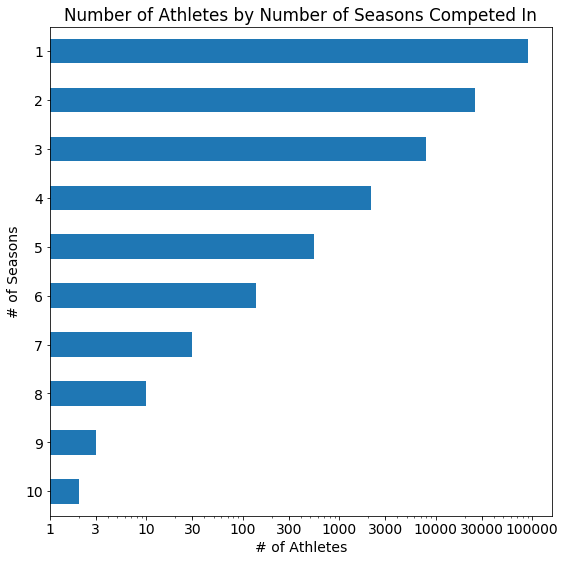

In [82]:
(
    df_athletes_explore
    .NSeasons
    .value_counts()
    .sort_values()
    .plot(kind='barh', color='C0', figsize=default_figsize, log=True)
)
labels_title(
    '# of Athletes', '# of Seasons',
    'Number of Athletes by Number of Seasons Competed In'
)
xticks = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]
plt.xticks(xticks, xticks);

The linearity of the log relationship here is striking.

### Age

Let's check the basic stats on age.

In [83]:
def describe_series(series):
    modes = series.mode().values
    if len(modes) == 1:
        modes = pd.Series({'mode': modes[0]})
    else:
        modes = pd.Series({'modes': modes})
    return series.describe().append(modes)

describe_series(df_season_athletes_explore.Age)

count    179029.000000
mean         25.602416
std           5.717367
min          10.000000
25%          22.000000
50%          25.000000
75%          28.000000
max          72.000000
mode         23.000000
dtype: float64

And now a histogram.

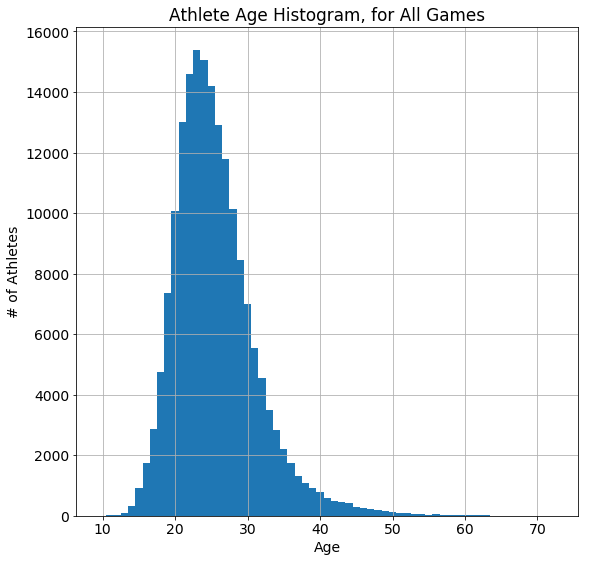

In [84]:
histogram_of_series_with_bin_size(df_season_athletes_explore.Age, 1)
labels_title('Age', '# of Athletes', 'Athlete Age Histogram, for All Games')

Here we have a right-tailed distribution peaking at 23. The majority of athletes have been between 20 and 30 years old, and it appears that there have been about as many athletes older than 30 as younger than 20.

### Country

Let's see a barplot of the top 20 countries by number of athletes sent over all time, including athletes who went multiple times.

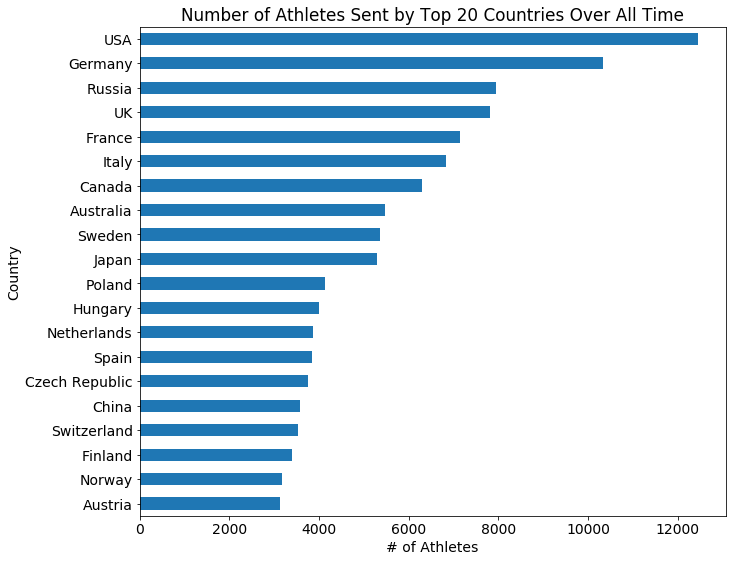

In [85]:
recent_athlete_countries = df_season_athletes_explore.Country

barplot_of_top_n_of_series(20, recent_athlete_countries, figsize=(10.5, 9))
labels_title(
    '# of Athletes', 'Country',
    'Number of Athletes Sent by Top 20 Countries Over All Time'
)

The US and Germany stand out far ahead of the rest.

### Year

A histogram of the `Year` variable results in a count of athletes over time. We will make our bins 4 years long -- usually this will give us one winter season and one summer season per bin.

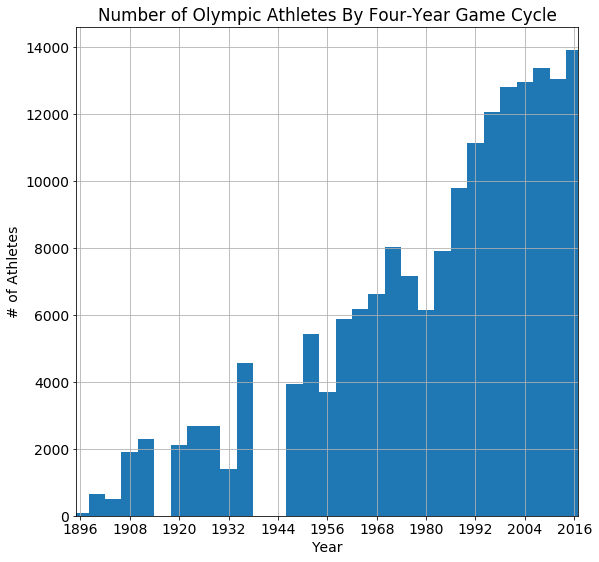

In [86]:
histogram_of_series_with_bin_size(df_season_athletes_explore.Year, 4)
labels_title(
    'Year', '# of Athletes',
    'Number of Olympic Athletes By Four-Year Game Cycle'
)

use_default_year_settings_for_x_axis()

No Olympic games occurred in 1916, 1940, or 1944, due to World Wars I and II. (See [Wikipedia](https://en.wikipedia.org/wiki/Olympic_Games#War_and_terrorism) for more info.)

### Season

In [87]:
percent_athlete_entries_in_winter = (df_explore.Season == 'Winter').mean()
percent_athlete_entries_in_winter

0.18672622846202935

Winter is a much smaller season for the Olympics, comprising only 18% of the athlete event entries over time.

### Sport

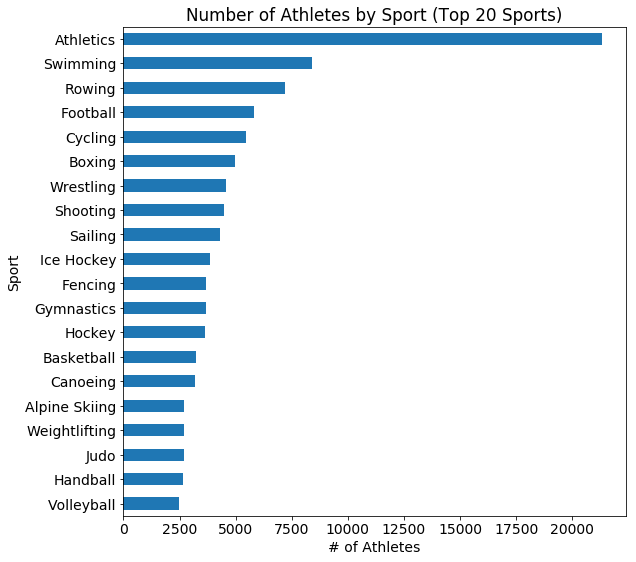

In [88]:
unique_athlete_sport_pairs = (
    df_explore[['AthleteID', 'Sport']].drop_duplicates().Sport)
barplot_of_top_n_of_series(20, unique_athlete_sport_pairs)
labels_title(
    '# of Athletes', 'Sport',
    'Number of Athletes by Sport (Top 20 Sports)'
)

Athletics dominates, with Ice Hockey taking the top spot for the Winter Olympics. Let's see what percent of athletes these sports attract.

In [89]:
sport_counts = (
    df_explore[['AthleteID', 'Sport']].drop_duplicates()
    .groupby('Sport').count()
)
season_counts = (
    df_explore[['AthleteID', 'Season']].drop_duplicates()
    .groupby('Season').count()
)

(
    sport_counts[sport_counts.index == 'Athletics'].AthleteID[0] / 
    season_counts[season_counts.index == 'Summer'].AthleteID[0]
), (
    sport_counts[sport_counts.index == 'Ice Hockey'].AthleteID[0] / 
    season_counts[season_counts.index == 'Winter'].AthleteID[0]
)


(0.19533247203056708, 0.2055531869537412)

Each has attracted about one-fifth of the athletes of its season (Summer or Winter).

### Team Event

In [90]:
df_explore.IsTeamEvent.mean()

0.3886020382510491

About 39% of entries in Olympic events were for team events.

## Bivariate
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

We will consider the following pairs of variables:
* Sex Ratio by Year
* NPreviousSeasons by Year
* Age by Sex
* Age by Year
* Age by Country
* Age by Season
* Age by Sport
* Age by Event
* Age by Medal
* Age by NPreviousSeasons
* Age by IsTeamEvent

In [91]:
df_explore.head()

,AthleteID,Sex,Age,Country,Year,Season,Sport,Event,Medal,NPreviousSeasons,IsTeamEvent
0,35698,M,22,Australia,1896,Summer,Athletics,Athletics Men's 800 metres,Gold,0,False
1,35698,M,22,Australia,1896,Summer,Athletics,"Athletics Men's 1,500 metres",Gold,0,False
2,35698,M,22,Australia,1896,Summer,Athletics,Athletics Men's Marathon,None,0,False
3,107090,M,34,Denmark,1896,Summer,Athletics,Athletics Men's 100 metres,None,0,False
4,54456,M,21,Denmark,1896,Summer,Athletics,Athletics Men's Shot Put,None,0,False


### Sex Ratio by Year

Creating a new feature `IsFemale` for `df_explore` will make it easier to get the sex ratio for each year, by allowing us to simply take the mean of `IsFemale`.

In [92]:
df_explore['IsFemale'] = df_explore.Sex == 'F'
df_explore[['Sex', 'IsFemale']].sample(5)

,Sex,IsFemale
47070,M,False
129441,M,False
97803,M,False
12688,M,False
183062,M,False


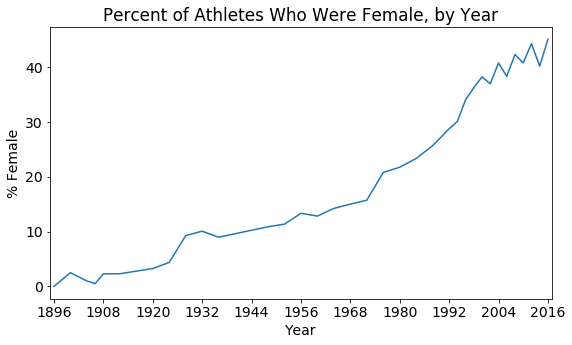

In [93]:
percent_female_by_year = (
    df_explore[['AthleteID', 'IsFemale', 'Year']]
    .drop_duplicates()
    .groupby('Year')
    .IsFemale
    .mean()
    * 100
)
plt.figure(figsize=(default_figwidth, 5))
plt.plot(percent_female_by_year.index, percent_female_by_year)
use_default_year_settings_for_x_axis()
labels_title(
    'Year', '% Female',
    'Percent of Athletes Who Were Female, by Year'
)

There was extreme marginalization of women in the early days of the Olympics; however, there has been a strong trend of increasing inclusion of women as athletes over time. Inclusion of women on the committee, however, is another matter. (See https://en.wikipedia.org/wiki/Participation_of_women_in_the_Olympics.)

### NPreviousSeasons by Year

Let's create a new boolean feature to indicate whether an Athlete in a particular Olympiad had any experience in previous Olympic games.

In [94]:
df_explore['HasPrevExp'] = df_explore.NPreviousSeasons > 0

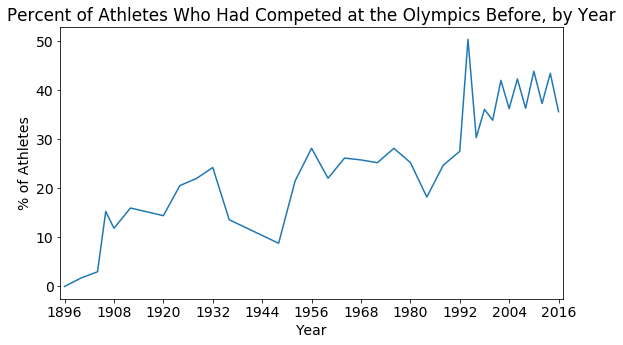

In [95]:
# Now, let's create a line graph.
percent_repeat_athletes_by_year = (
    df_explore[['AthleteID', 'HasPrevExp', 'Year']]
    .drop_duplicates()
    .groupby(['Year'])
    .HasPrevExp.mean() * 100
)
plt.figure(figsize=(default_figwidth, 5))
plt.plot(percent_repeat_athletes_by_year)
use_default_year_settings_for_x_axis()
labels_title(
    'Year', '% of Athletes',
    'Percent of Athletes Who Had Competed at the Olympics Before, by Year'
)

There is a general trend toward increasingly more returning athletes which seems to have slowed or stalled over the past ~15 years. The spike in 1994 could be due to the relaxation of amateurism rules in some activities. (https://en.wikipedia.org/wiki/1994_Winter_Olympics#Figure_skating)

### Age by Sex

In [96]:
(df_explore[['AthleteID', 'Sex', 'Age']]
 .drop_duplicates().groupby('Sex').Age.mean())

Sex
M    26.066557
F    24.348156
Name: Age, dtype: float64

The mean age for all of the men is about 1.7 years older than for women. (See https://www.quora.com/Athletically-do-female-and-male-athletes-peak-at-different-ages for some discussion of this topic.)

### Age by Year

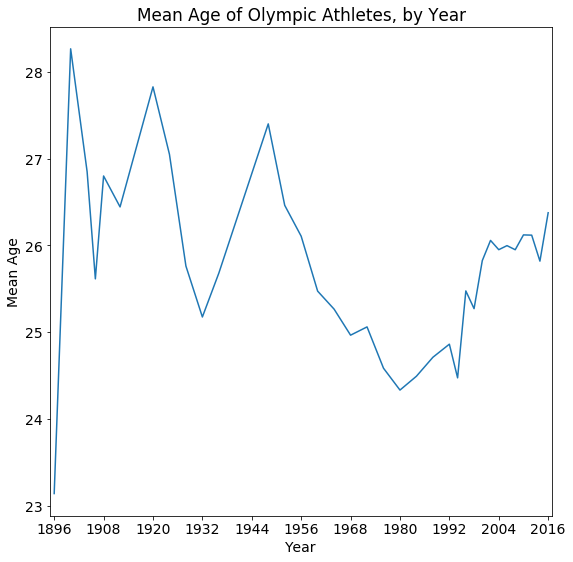

In [97]:
def remove_duplicate_athletes_by_year(df):
    return (
        df.groupby(['AthleteID', 'Year'])
        .Age.mean() # or min() or max(): the ages are same for a given athlete.
        .to_frame()
        .reset_index()
    )

age_by_year = (
    remove_duplicate_athletes_by_year(df_explore)
    .groupby('Year')
    .Age
    .mean()
)
plt.figure(figsize=default_figsize)
plt.plot(age_by_year);
labels_title('Year', 'Mean Age', 'Mean Age of Olympic Athletes, by Year')
use_default_year_settings_for_x_axis()

There is a lot of volatility in the early years. The first Olympiad has the lowest mean age of any. Recall that in the earlier years there were few athletes, and even fewer that we have ages for. Thus, our early data might not be as accurate. Even so, we will investigate a little bit there to see if we can gain any insight about the 5-year age jump from 1896 to 1900.

The two peaks at 1920 and 1948 coincide with post-war games. One could surmise that many athletes who had planned on competing in the canceled 1916, 1940, or 1944 games waited (and aged) until the next Olympics season, and that many younger would-be athletes were unable to practice for the Olympics during the harsh war years.

After the second Olympics, there is overall a large decrease in mean age until 1980.

The large increase from 1980 on may be caused by the increasing acceptance of professional athletes into the Olympics. See the following for more info on this topic:
* https://pc2018.com/amateurism-in-the-olympics/
* https://sports.vice.com/en_us/article/gvaqdm/for-love-or-for-money-a-history-of-amateurism-in-the-olympic-games
* https://www.uta.edu/english/sla/br170110.html

Interestingly, this age increase over the past ~30 years runs counter to the idea that athletes' ages are decreasing. Even so, it could be that the spread of the ages is increasing and that people's memories hold onto the extreme cases of young athletes most. Let's test that idea by examining boxplots of the age over time.

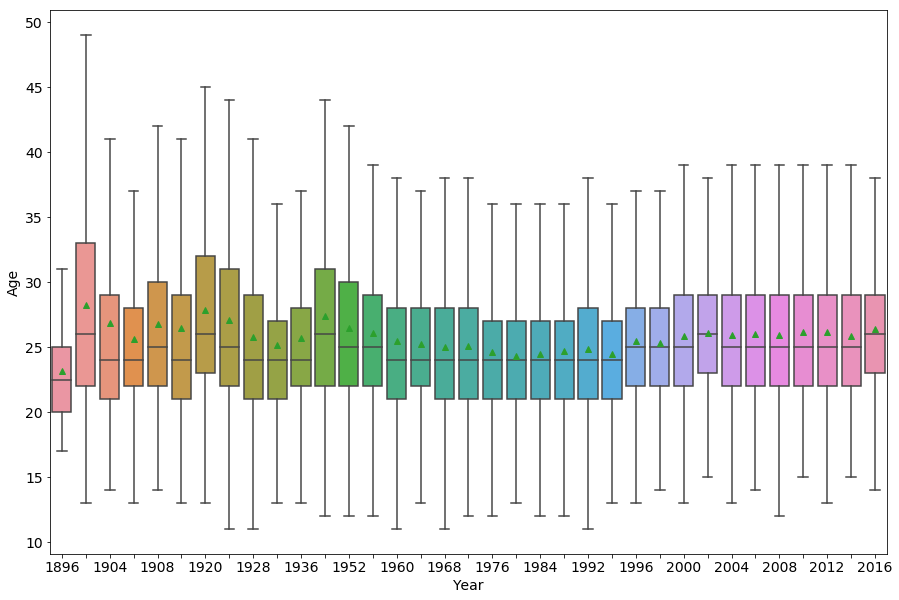

In [98]:
df_ages = remove_duplicate_athletes_by_year(df_explore)
# years_to_use = filter(lambda x: x % 8 == 0, df_ages.Year.tolist())

plt.figure(figsize=(15, 10))
sns.boxplot(
    data=df_ages,#[df_ages.Year.isin(years_to_use)],
    y='Age', x='Year', showfliers=False, showmeans=True);

# plt.axes().tick_params(labelbottom=False)
# xticks = range(1900, 2020, 20)
# list(xticks)
xticks = map(lambda x: '' if x == 0 else x, (np.array(range(0, 35)) % 2 == 0) * np.array(sorted(df_ages.Year.unique().tolist())))
plt.xticks(ticks=range(0, 35), labels=xticks);
# plt.ylim(20.9, 31.1);


Not seeing any significant decrease here either. Let's look at a couple age histograms for more detail.

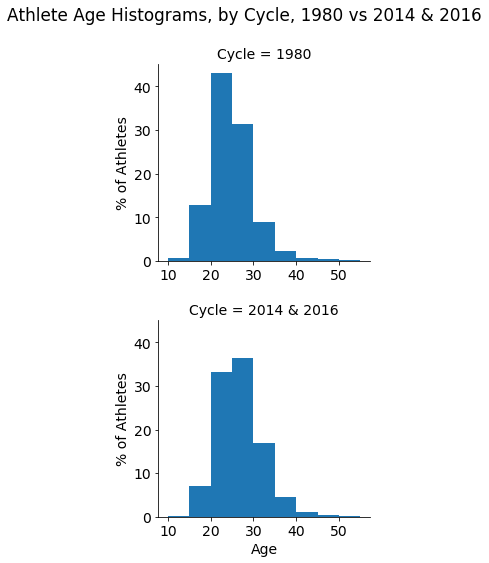

In [99]:
df_season_athletes_limited = (
    df_season_athletes_explore
    [
        (df_season_athletes_explore.Year == 1980) |
        (df_season_athletes_explore.Year >= 2014)
    ].copy()
)
# Used https://stackoverflow.com/a/45037219/576101.
df_season_athletes_limited['Cycle'] = (
    np.where(df_season_athletes_limited.Year >= 2014, '2014 & 2016', '1980'))
df_season_athletes_limited = df_season_athletes_limited.sort_values('Cycle')
df_season_athletes_limited['% of Athletes'] = (
    get_weights_for_norm_hist(df_season_athletes_limited, 'Cycle')
)

g = sns.FacetGrid(df_season_athletes_limited, row='Cycle', height=4)
g.map(weighted_hist, 'Age', '% of Athletes', bins=range(10, 56, 5))
g.fig.subplots_adjust(top=0.88, hspace=0.3)
g.fig.suptitle('Athlete Age Histograms, by Cycle, 1980 vs 2014 & 2016');
xticks = range(10, 56, 10)
plt.xticks(xticks, xticks);

repeat_facetgrid_ticklabels()

There is not any shift to younger athletes here either in any of the younger bins. Of course, there are many other factors that could be at play as well: for example, the age trend for Figure Skating might be different than the general trend, or the age trend for medalists might be different than non-medalists, or some kind of shift to younger athletes in the distribution might have occurred more recently than the 1980. We will explore such issues in the Multivariate section later.

Now let's back up and check on that huge difference in mean age (5 years) from 1896 to 1900. Perhaps it has something to do with the particular sports offered?

In [100]:
sports_1896 = set(df_explore[df_explore.Year == 1896].Sport.unique())
print(sports_1896)

{'Shooting', 'Athletics', 'Cycling', 'Swimming', 'Fencing', 'Tennis', 'Wrestling', 'Gymnastics', 'Weightlifting'}


In [101]:
sports_1900 = set(df_explore[df_explore.Year == 1900].Sport.unique())
print(sports_1900)

{'Shooting', 'Rowing', 'Equestrianism', 'Athletics', 'Tug-Of-War', 'Football', 'Cycling', 'Cricket', 'Golf', 'Sailing', 'Swimming', 'Fencing', 'Water Polo', 'Rugby', 'Croquet', 'Tennis', 'Gymnastics', 'Polo', 'Basque Pelota', 'Archery'}


Indeed, many more sports were added in 1900. Perhaps the mean ages of these sports tend to be higher. We will explore the mean ages of various sports in a later section. Let's see which sports remained constant for both Olympic years.

In [102]:
sports_1896_1900 = sports_1896.intersection(sports_1900)
sports_1896_1900

{'Athletics',
 'Cycling',
 'Fencing',
 'Gymnastics',
 'Shooting',
 'Swimming',
 'Tennis'}

Quite a few. Let's see what the mean age is for all of these sports for 1896 and also for 1900.

In [103]:
df_explore[
    (df_explore.Year.isin([1896, 1900])) &
    (df_explore.Sport.isin(sports_1896_1900))
].groupby('Year').Age.mean()

Year
1896    23.625000
1900    27.658466
Name: Age, dtype: float64

Well, that hypothesis didn't hold. The age jump for all of the sports from 1896 to 1900 was about 5 years, and this is still 4. So, indeed, the change in sports might account for some of the age change but not much of it. Perhaps the countries participating changed?

In [104]:
countries_1896 = set(df_explore[df_explore.Year == 1896].Country.unique())
print(countries_1896)

{'Switzerland', 'Denmark', 'Sweden', 'UK', 'Australia', 'France', 'Germany', 'Hungary', 'USA', 'Greece', 'Austria'}


In [105]:
countries_1900 = set(df_explore[df_explore.Year == 1900].Country.unique())
print(countries_1900)

{'Italy', 'Czech Republic', 'Brazil', 'Denmark', 'Norway', 'Germany', 'Haiti', 'Hungary', 'USA', 'Peru', 'Romania', 'Cuba', 'Argentina', 'Russia', 'Netherlands', 'UK', 'Canada', 'Greece', 'Switzerland', 'Colombia', 'New Zealand', 'Luxembourg', 'Spain', 'Sweden', 'India', 'Belgium', 'Australia', 'France', 'Mexico', 'Austria'}


Indeed, many more countries in 1900 than in 1896. Let's see how mean age compares for the same countries from 1896 to 1900.

In [106]:
countries_1896_1900 = countries_1896.intersection(countries_1900)
print(countries_1896_1900)

{'Denmark', 'Sweden', 'UK', 'Australia', 'France', 'Germany', 'Hungary', 'USA', 'Greece', 'Switzerland', 'Austria'}


Looks like every country that participated in 1896 also participated in 1900.

In [107]:
df_explore[
    (df_explore.Year.isin([1896, 1900])) &
    (df_explore.Sport.isin(sports_1896_1900)) &
    (df_explore.Country.isin(countries_1896_1900))
].groupby('Year').Age.mean()

Year
1896    23.625000
1900    27.093972
Name: Age, dtype: float64

Well, we are down just slightly more in the age gap. Let's leave out returning athletes.

In [108]:
df_explore[
    (df_explore.Year.isin([1896, 1900])) &
    (df_explore.Sport.isin(sports_1896_1900)) &
    (df_explore.Country.isin(countries_1896_1900)) &
    (df_explore.NPreviousSeasons == 0)
].groupby('Year').Age.mean()

Year
1896    23.625000
1900    27.114754
Name: Age, dtype: float64

This result is certainly counterintuitive. The mean age of the new athletes was about the same, even just a hair older than the returning athletes. Something seems to be dramatically different about the 1900 Olympics vs the 1896 Olympics. At this point, it seems reasonable to do some qualitative investigation online about the 1900 Olympics. What was so unusual about them?

Ah, well, here is an interesting piece of information:
"The Games of 1900 were held in Paris as part of the World's Fair. The organisers spread the competitions over five months and under-promoted their Olympic status to such an extent that many athletes never knew they had actually participated in the Olympic Games." (https://www.olympic.org/paris-1900)

So, we could imagine then that the World's Fair may have attracted older individuals than the Olympics themselves tend to attract, so that the year 1900 should be treated as an anomaly.

That still doesn't explain why subsequent years still had so much higher mean ages than 1896. Let's check on 1904.

Indeed, the World's Fair also coincided with the 1904 Olympics as well: "Unfortunately, the St Louis Games repeated all of the mistakes of 1900. The various competitions were spread out over four-and-a-half months and became lost in the chaos of a World’s Fair celebrating the purchase of the Louisiana territory from France." (https://www.olympic.org/st-louis-1904)

It appears that the 1906 Olympics were conducted more in line with how we'd expect (https://en.wikipedia.org/wiki/1906_Intercalated_Games). Let's compare 1896 and 1906, and get a little more exact in our comparison.

In [109]:
def intersection_of_events_in_years(df, year1, year2):
    events1 = set(df_explore[df_explore.Year == year1].Event.unique())
    events2 = set(df_explore[df_explore.Year == year2].Event.unique())
    return events1.intersection(events2)

def intersection_of_countries_in_years(df, year1, year2):
    countries1 = set(df_explore[df_explore.Year == year1].Country.unique())
    countries2 = set(df_explore[df_explore.Year == year2].Country.unique())
    return countries1.intersection(countries2)

events = intersection_of_events_in_years(df_explore, 1896, 1906)
countries = intersection_of_countries_in_years(df_explore, 1896, 1906)

df_explore[
    (df_explore.Year.isin([1896, 1906])) &
    (df_explore.Event.isin(events)) &
    (df_explore.Country.isin(countries)) &
    (df_explore.NPreviousSeasons == 0) &
    (df_explore.Sex == 'M')
].groupby('Year').Age.mean()

Year
1896    22.171171
1906    24.121359
Name: Age, dtype: float64

We still have a gap of about 2 years. Well, that doesn't seem quite as surprising. And we still have to remember that we are missing a fair amount of age data from this time period. In any case, there was a significant increase in the mean age of athletes after the first Olympiad. It is not clear why the participants in the first Olympiad were so young.

### Age by Country

Given how much the mean age has fluctuated over time, let's limit our bivariate analysis of Age by Country to just the most recent games cycle (2014 and 2016). First, we'll look at a histogram of the countries across different age ranges. Then we'll look at the mean ages for each of the top 20 countries, by number of athletes sent over time.

In [110]:
df_explore_recent = df_explore[df_explore.Year >= 2014].copy()

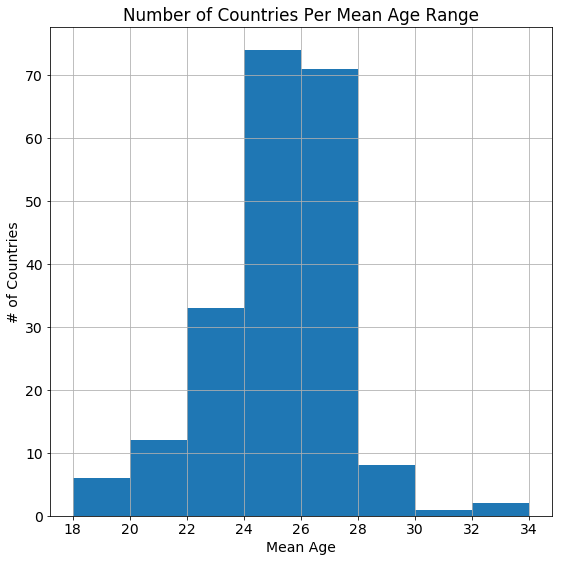

In [111]:
age_by_country = (
    df_explore_recent
    .groupby('Country')
    .Age
    .mean()
    .sort_values()
)
plt.figure(figsize=default_figsize)
age_by_country.hist(bins=range(18, 35, 2));
labels_title(
    'Mean Age', '# of Countries', 'Number of Countries Per Mean Age Range'
)

We saw earlier that the mean age for all time across all countries was 25.6. So this chart matches that. However, this distribution has a fatter tail on the left, but the overall age distribution actually had a fatter tail on the right.

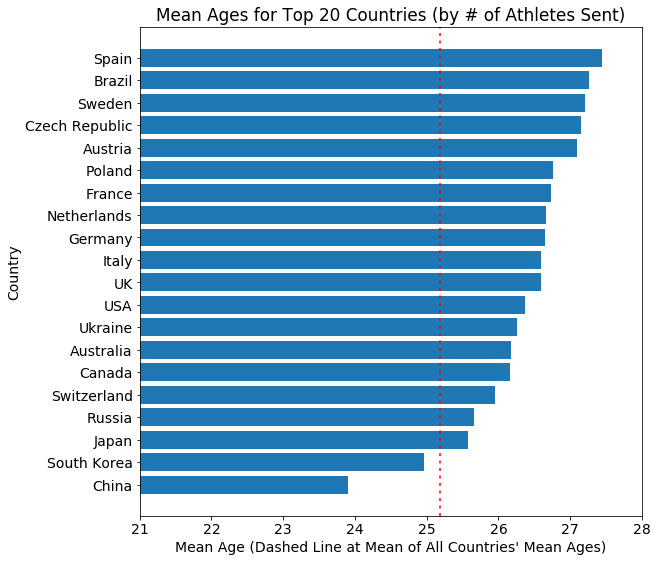

In [112]:
top_country_counts_recent = df_explore_recent.Country.value_counts().head(20)
top_countries_recent = top_country_counts_recent.index.tolist()
age_by_country = (
    df_explore_recent[df_explore_recent.Country.isin(top_countries_recent)]
    .groupby('Country')
    .Age
    .mean()
    .sort_values()
)
mean_mean_age = (
    df_explore_recent
    .groupby('Country')
    .Age
    .mean()
    .sort_values()
    .mean()
)
plt.figure(figsize=default_figsize)
plt.barh(age_by_country.index, age_by_country);
plt.xlim(21, 28);
plt.axvline(mean_mean_age, color='r', dashes=(2, 3))
labels_title(
    'Mean Age (Dashed Line at Mean of All Countries\' Mean Ages)', 'Country',
    'Mean Ages for Top 20 Countries (by # of Athletes Sent)')

Most of the countries most involved in the Olympics have a higher-than-average mean age for their athletes. China and South Korea stand out among these countries for sending athletes younger than the mean of all countries' mean ages. Apparently the most involved countries tend to send older athletes.

### Age by Season

We'll run this analysis across all time, since just one occurrence each of Winter and Summer might not provide us with much data for an age histogram.

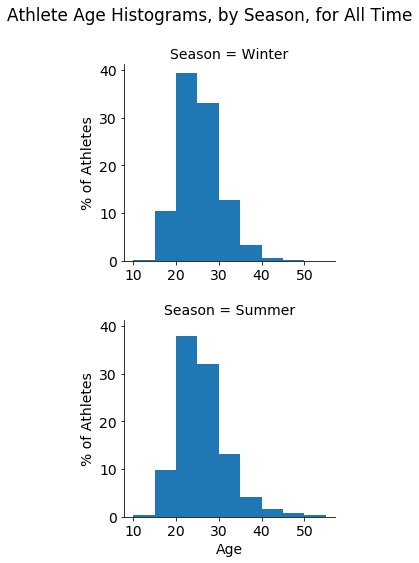

In [113]:
df_season_athletes_weights = df_season_athletes_explore.sort_values('Season')
weights = get_weights_for_norm_hist(df_season_athletes_explore, 'Season')
df_season_athletes_weights['% of Athletes'] = weights
g = sns.FacetGrid(df_season_athletes_weights, row='Season', height=4)
g.map(weighted_hist, 'Age', '% of Athletes', bins=range(10, 56, 5))
g.fig.subplots_adjust(top=0.88, hspace=0.3)
g.fig.suptitle('Athlete Age Histograms, by Season, for All Time');
repeat_facetgrid_ticklabels()

The distributions are very similar.

In the Multivariate section, we will explore the change in age distribution over time for both Winter and Summer seasons, independently.

### Age by Sport

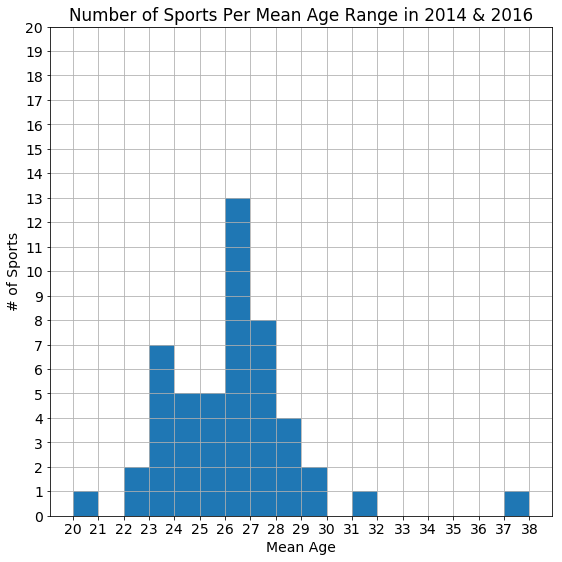

In [114]:
age_by_sport = (
    df_explore_recent[['AthleteID', 'Age', 'Sport']]
    .drop_duplicates()
    .groupby('Sport').Age.mean().sort_values()
)

plt.figure(figsize=default_figsize)
bins = range(20, 39, 1)
age_by_sport.hist(bins=bins)
plt.xticks(bins, bins)
yticks = range(0, 21, 1)
plt.yticks(yticks, yticks)
labels_title(
    'Mean Age', '# of Sports', 'Number of Sports Per Mean Age Range in 2014 & 2016'
)

Between 26 and 27 is the most common mean age range among sports, in recent Olympics. Let's look at a few in particular.

In [115]:
print(age_by_sport.head(10))
print(age_by_sport.tail(10))

Sport
Rhythmic Gymnastics          20.250000
Gymnastics                   22.474490
Swimming                     22.536093
Figure Skating               23.402685
Diving                       23.433824
Synchronized Swimming        23.539216
Short Track Speed Skating    23.754717
Football                     23.769556
Ski Jumping                  23.927083
Freestyle Skiing             23.938931
Name: Age, dtype: float64
Sport
Table Tennis        27.738372
Skeleton            27.891304
Handball            28.002833
Tennis              28.035714
Bobsleigh           28.459302
Beach Volleyball    28.687500
Golf                29.525000
Curling             29.804598
Shooting            31.353846
Equestrianism       37.465000
Name: Age, dtype: float64


Gymnastics sports have the youngest spots, and Equestrianism is at the top, far higher than the others.

### Age by Event

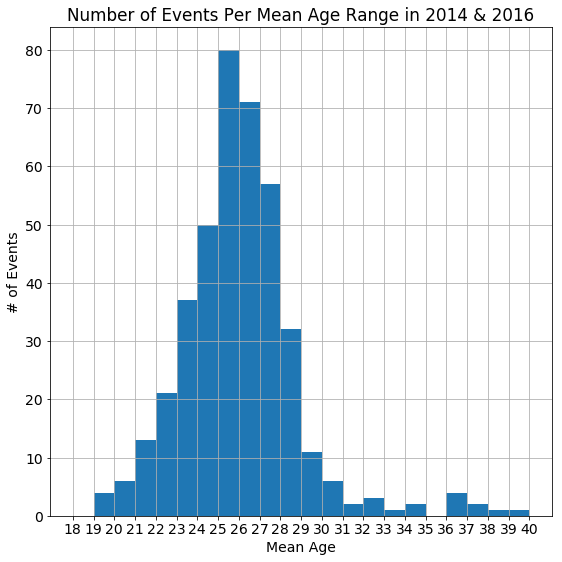

In [116]:
age_by_event = df_explore_recent.groupby('Event').Age.mean().sort_values()

plt.figure(figsize=default_figsize)
bins = range(18, 41, 1)
age_by_event.hist(bins=bins)
plt.xticks(bins, bins)
yticks = range(0, 81, 10)
plt.yticks(yticks, yticks)
labels_title(
    'Mean Age', '# of Events', 'Number of Events Per Mean Age Range in 2014 & 2016'
)

Interestingly the peak mean age for Events is a little lower than it is for Sports, at between 25 and 26.

In [117]:
print(age_by_event.head())
print(age_by_event.tail())

Event
Gymnastics Women's Team All-Around          19.166667
Gymnastics Women's Uneven Bars              19.772152
Gymnastics Women's Individual All-Around    19.819672
Gymnastics Women's Floor Exercise           19.926829
Figure Skating Women's Singles              20.166667
Name: Age, dtype: float64
Event
Equestrianism Mixed Three-Day Event, Team    36.784314
Equestrianism Mixed Dressage, Team           37.318182
Equestrianism Mixed Dressage, Individual     37.550000
Equestrianism Mixed Jumping, Individual      38.666667
Equestrianism Mixed Jumping, Team            39.133333
Name: Age, dtype: float64


Figure Skating had a higher mean age than Swimming, for Sports, but here Women's Figure Skating in particular comes in lower than any Swimming events.

### Age by Medal

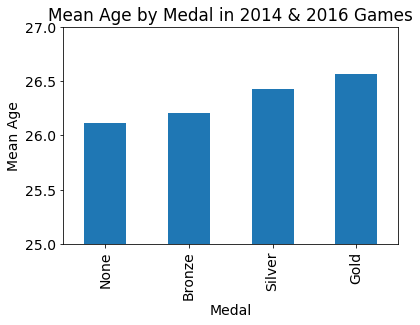

In [118]:
age_by_medal = df_explore_recent.groupby('Medal').Age.mean()
age_by_medal.plot(kind='bar', color='C0')
plt.ylim(25, 27)
labels_title('Medal', 'Mean Age', 'Mean Age by Medal in 2014 & 2016 Games')

It turns out that modern medalists are actually slightly older than the non-medalists, and each medal higher up corresponds to a slightly higher mean age. These are small differences however that add up to less than half a year.

### Age by NPreviousSeasons

In [119]:
age_by_nseasons = df_explore_recent.groupby('NPreviousSeasons').Age.mean()
age_by_nseasons

NPreviousSeasons
0    24.173288
1    27.232385
2    30.192865
3    33.781447
4    37.807512
5    41.915254
6    46.909091
7    50.250000
Name: Age, dtype: float64

These numbers are about as we'd expect, with almost 4 years gap in mean age between each group, on average.

### Age by IsTeamEvent

In [120]:
age_by_team_event = df_explore_recent.groupby('IsTeamEvent').Age.mean()
age_by_team_event

IsTeamEvent
False    25.984271
True     26.415417
Name: Age, dtype: float64

These numbers are pretty close. It seems that we probably won't find anything of much interest with the IsTeamEvent variable.

## Multivariate
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In [121]:
df_explore.head(3)

,AthleteID,Sex,Age,Country,Year,Season,Sport,Event,Medal,NPreviousSeasons,IsTeamEvent,IsFemale,HasPrevExp
0,35698,M,22,Australia,1896,Summer,Athletics,Athletics Men's 800 metres,Gold,0,False,False,False
1,35698,M,22,Australia,1896,Summer,Athletics,"Athletics Men's 1,500 metres",Gold,0,False,False,False
2,35698,M,22,Australia,1896,Summer,Athletics,Athletics Men's Marathon,None,0,False,False,False


We will examine the following variable combinations:
* `NPreviousSeasons`, `Year`, `Sex`
* `Age`, `Sex`, `Medal`
* `Age`, `Year`, `Sex`
* `Age`, `Year`, `Country`
* `Age`, `Year`, `Season`
* `Age`, `Year`, `Sport`
* `Age`, `Year`, `Medal`
* `Age`, `Year`, `Sex`, `Medal`
* `Age`, `Year`, `Sex`, `Country`
* `Age`, `Year`, `Sex`, `Season`
* `Age`, `Year`, `Sex`, `Sport`

### NPreviousSeasons, Year, Sex

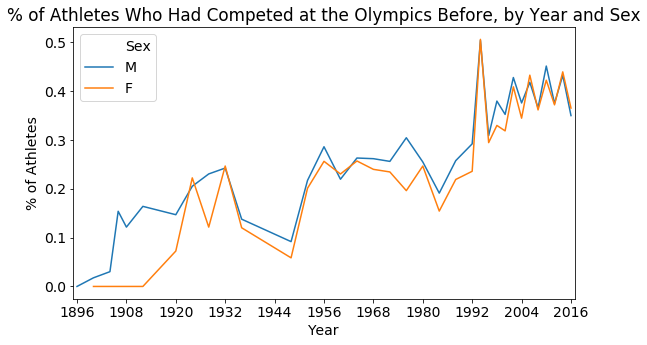

In [122]:
percent_repeat_athletes_by_year = (
    df_explore[['AthleteID', 'HasPrevExp', 'Year', 'Sex']]
    .drop_duplicates()
    .groupby(['Year', 'Sex'])
    .HasPrevExp.mean()
    .to_frame()
    .reset_index()
)
plt.figure(figsize=(default_figwidth, 5))
sns.lineplot(
    data=percent_repeat_athletes_by_year,
    x='Year', y='HasPrevExp', hue='Sex'
)
use_default_year_settings_for_x_axis()
labels_title(
    'Year', '% of Athletes',
    '% of Athletes Who Had Competed at the Olympics Before, by Year and Sex'
)

Pretty similar trends for both sexes for the most part.

### Age, Sex, Medal

In [123]:
df_age_by_sex_medal = df_explore.groupby(['Sex', 'Medal']).Age.mean()
df_age_by_sex_medal

Sex  Medal 
M    None      25.903873
     Bronze    26.277264
     Silver    26.542077
     Gold      26.426525
F    None      23.496963
     Bronze    24.677754
     Silver    24.430604
     Gold      24.370024
Name: Age, dtype: float64

There are more marked differences among the mean ages among the athlete medal groups for women than for men. The most important differences here seem to be between medalists and non-medalists, within each sex. Let's simplify the data to see that more clearly.

In [124]:
df_explore['WonMedal'] = df_explore.Medal != 'None'
df_age_by_sex_wonmedal = df_explore.groupby(['Sex', 'WonMedal']).Age.mean()
df_age_by_sex_wonmedal

Sex  WonMedal
M    False       25.903873
     True        26.414676
F    False       23.496963
     True        24.493141
Name: Age, dtype: float64

Here we have a 1.0-year difference for females and a 0.5-year difference for males. Let's see what those differences are for the most recent Olympic games.

In [125]:
df_age_by_sex_medal = df_explore_recent.groupby(['Sex', 'Medal']).Age.mean()
df_age_by_sex_medal

Sex  Medal 
M    None      26.612272
     Bronze    26.844720
     Silver    26.725843
     Gold      27.264192
F    None      25.467056
     Bronze    25.464115
     Silver    26.105651
     Gold      25.789731
Name: Age, dtype: float64

Not so much of a trend here for women. In fact, women who get Bronze or nothing are about the same age. Clearly the age gap between female medalists and non-medalists has almost closed in recent years. We will explore this change over time in more depth later.

### Age, Year, Sex

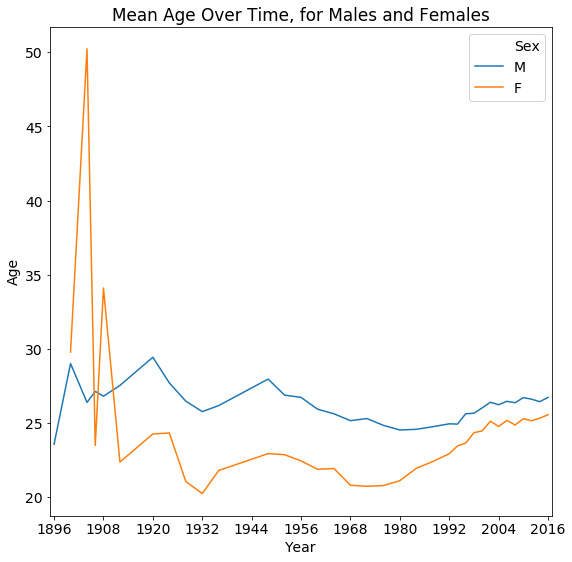

In [126]:
df_age_by_year_sex = (
    df_explore.groupby(['Sex', 'Year']).Age.mean().to_frame().reset_index()
)
plt.figure(figsize=default_figsize)
fig = sns.lineplot(
    data=df_age_by_year_sex, x='Year', y='Age', hue='Sex', hue_order=['M', 'F']
)
plt.title('Mean Age Over Time, for Males and Females')
use_default_year_settings_for_x_axis()

A couple observations:
* There is a lot of volatility in women's mean age from 1900 to 1912. It is far greater than the fluctuations we see for men.
* The gap in mean age between men and women has been fairly large throughout most of Olympic history, but has gotten much smaller in recent times, especially since around 1970.

Let's investigate the wild fluctuations in women's mean age in the early 1900's. Was it related to the sports offered for women in each Olympic game season?

In [127]:
df_explore[df_explore.Sex == 'F'].groupby('Year').Sport.unique().head(6)

Year
1900                     [Croquet, Golf, Sailing, Tennis]
1904                                            [Archery]
1906                                             [Tennis]
1908                    [Archery, Figure Skating, Tennis]
1912                           [Diving, Swimming, Tennis]
1920    [Diving, Figure Skating, Sailing, Swimming, Te...
Name: Sport, dtype: object

Possibly. Archery is only present in both of the age peaks. What are the mean ages for each sport for women in that time period?

In [128]:
df_explore[
    (df_explore.Year <= 1930) & (df_explore.Sex == 'F')
].groupby(['Sport']).Age.mean().sort_values().tail(8)

Sport
Athletics         20.724138
Figure Skating    26.218750
Tennis            29.012346
Fencing           29.648649
Sailing           30.285714
Golf              30.750000
Croquet           39.500000
Archery           44.093750
Name: Age, dtype: float64

Indeed, Archery has the highest mean age, for women. How do things look if we take out Archery?

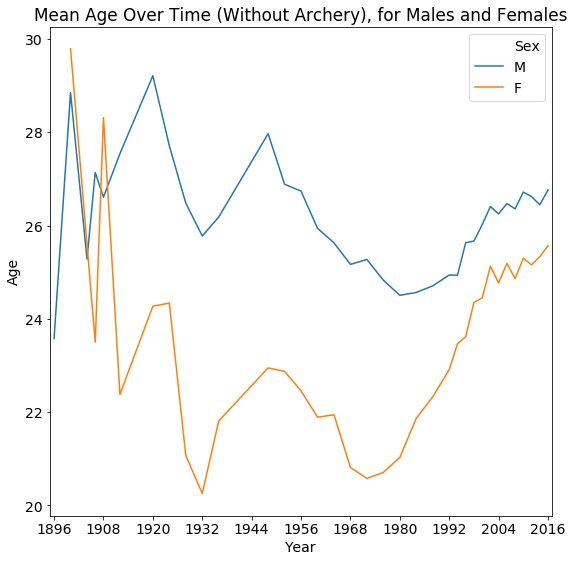

In [129]:
df_age_by_year_sex_no_archery = (
    df_explore[df_explore.Sport != 'Archery']
    .groupby(['Sex', 'Year'])
    .Age
    .mean()
    .to_frame()
    .reset_index()
)
plt.figure(figsize=default_figsize)
fig = sns.lineplot(
    data=df_age_by_year_sex_no_archery,
    x='Year', y='Age', hue='Sex', hue_order=['M', 'F']
)
plt.title('Mean Age Over Time (Without Archery), for Males and Females')
use_default_year_settings_for_x_axis()

Now the ages are more in line with men's ages. However, let's investigate a little further. Tennis is present in most of the early games. Let's see if the mean age for women's Tennis changes much.

In [130]:
df_explore[
    (df_explore.Sport == 'Tennis') & (df_explore.Sex == 'F')
].groupby('Year').Age.mean().head()

Year
1900    23.888889
1906    23.500000
1908    31.083333
1912    29.466667
1920    29.755556
Name: Age, dtype: float64

Actually it does. There's a big jump from 1906 to 1908. Let's see if the Tennis events changed.

In [131]:
tennis_events_by_year = df_explore[
    (df_explore.Sex == 'F') & (df_explore.Sport == 'Tennis')
].groupby('Year').Event.unique().head()
for year, events in tennis_events_by_year.items():
    print(year, events)

1900 ["Tennis Women's Singles" 'Tennis Mixed Doubles']
1906 ["Tennis Women's Singles" 'Tennis Mixed Doubles']
1908 ["Tennis Women's Singles, Covered Courts" "Tennis Women's Singles"]
1912 ['Tennis Mixed Doubles, Covered Courts'
 "Tennis Women's Singles, Covered Courts" "Tennis Women's Singles"
 'Tennis Mixed Doubles']
1920 ["Tennis Women's Singles" 'Tennis Mixed Doubles' "Tennis Women's Doubles"]


The Tennis event types in 1900-1906 don't appear to be different than the ones in 1908-1920 in any consistent and relevant way. Perhaps some of the archers went and played tennis too? Let's check for overlap between Tennis and Archery players.

In [132]:
df_explore_female = df_explore[df_explore.IsFemale].copy()
female_tennis_athletes = (
    df_explore_female[df_explore_female.Sport == 'Tennis'].AthleteID.tolist()
)
female_archers = (
    df_explore_female[df_explore_female.Sport == 'Archery'].AthleteID.tolist()
)
set(female_tennis_athletes).intersection(set(female_archers))

set()

No, apparently there has never been any female Olympic athlete who participated in both sports. It looks like we can rule out the particular sports activities as the issue. Perhaps the participating countries changed?

In [133]:
df_explore[
    (df_explore.Year <= 1920) &
    (df_explore.Sex == 'F') &
    (df_explore.Sport == 'Tennis')
].groupby(['Year', 'Country']).Age.agg(['mean', 'count'])

mean  count
Year Country                         
1900 Czech Republic  35.000000      2
     France          13.000000      1
     UK              29.000000      2
     USA             18.500000      4
1906 France          21.000000      2
     Greece          26.000000      2
1908 Sweden          35.000000      2
     UK              30.300000     10
1912 Denmark         30.000000      2
     France          19.000000      2
     Germany         31.000000      2
     Norway          28.000000      2
     Sweden          30.125000     16
     UK              31.000000      6
1920 Belgium         33.727273     11
     Czech Republic  22.000000      1
     Denmark         27.000000      5
     France          20.500000      6
     Italy           25.000000      2
     Norway          29.000000      1
     Sweden          28.285714      7
     UK              34.250000     12

Indeed, the countries participating in women's Tennis did change completely from 1906 to 1908. Given how few countries were participating, it is not quite so odd that the mean age jumped around so much in the early years of the Olympics. Even more signicantly, we can see that the total number of women participating in Tennis was very low. Let's take a look more generally for all sports.

In [134]:
df_explore[
    (df_explore.Year <= 1920)
].groupby(['Year', 'Sex']).Age.agg(['mean', 'count'])

mean  count
Year Sex                  
1896 M    23.580645    217
1900 M    29.017825   1122
     F    29.791667     24
1904 M    26.396450   1014
     F    50.230769     13
1906 M    27.139959    986
     F    23.500000      4
1908 M    26.817424   2399
     F    34.105263     38
1912 M    27.542683   3772
     F    22.379310     87
1920 M    29.441629   3315
     F    24.272727    121

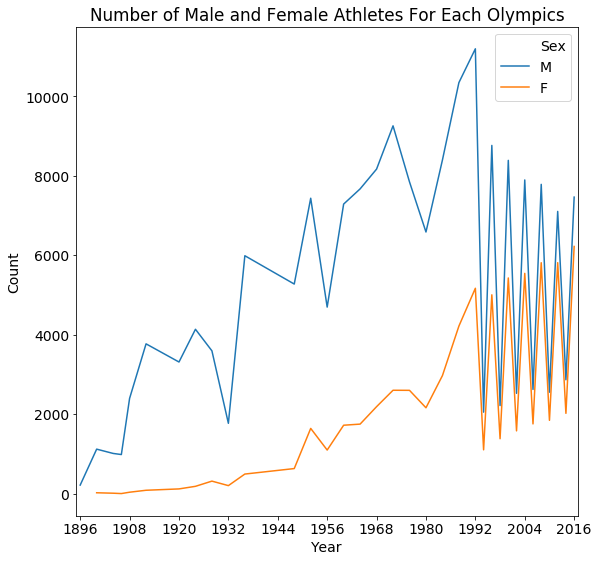

In [135]:
df_count_by_year_sex = (
    df_explore.groupby(['Year', 'Sex'])
    .AthleteID.count().to_frame().reset_index()
)
df_count_by_year_sex.rename(columns={'AthleteID': 'Count'}, inplace=True)

plt.figure(figsize=default_figsize)
fig = sns.lineplot(
    data=df_count_by_year_sex, x='Year', y='Count',
    hue='Sex', hue_order=['M', 'F']
)
plt.title('Number of Male and Female Athletes For Each Olympics')
use_default_year_settings_for_x_axis()

Indeed, we can reasonably attribute the greater volatility in women's mean ages to the the very small number of women participating in the first four game seasons. Here we also recall that we are missing the ages of some 20-40% of entries for some of these years.

(Note: The large dropoff occurs when the Winter Games was separated from the Summer Games.)

Let's go ahead and remove Archery from our data set.

In [136]:
df_explore = df_explore[df_explore.Sport != 'Archery'].copy()

### Age, Year, Country

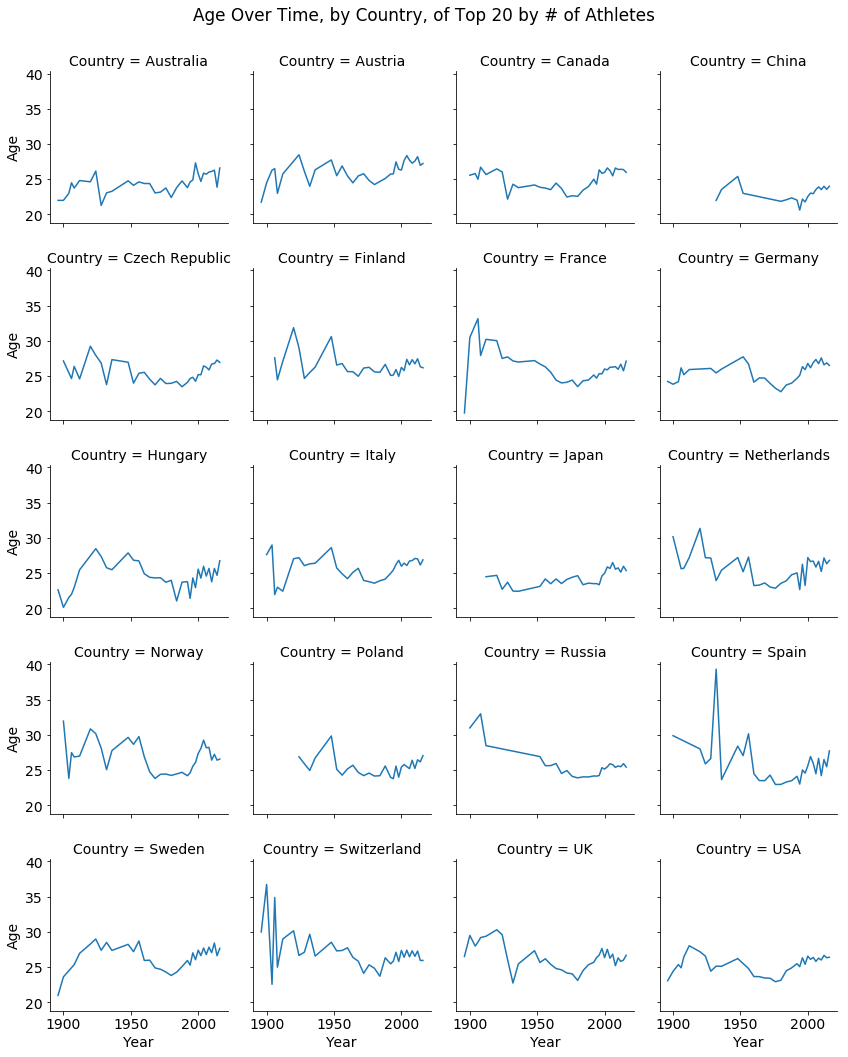

In [137]:
top_country_counts = df_explore.Country.value_counts().head(20)
top_countries = top_country_counts.index.tolist()

age_by_year_country = (
    df_explore
    [df_explore.Country.isin(top_countries)]
    .groupby(['Year', 'Country'])
    .Age
    .mean()
    .to_frame()
    .reset_index()
)
g = sns.FacetGrid(
    data=age_by_year_country,
    col='Country',
    col_wrap=4,
    col_order=sorted(top_countries)
)
g.map(plt.plot, 'Year', 'Age');
g.fig.subplots_adjust(top=0.92, hspace=0.3)
g.fig.suptitle('Age Over Time, by Country, of Top 20 by # of Athletes');

None of these countries seems to have a downtrend spanning the past few decades, but Norway comes closest to it.

### Age, Year, Season

In [138]:
cycles = ((df_explore['Year'] - 1896) / 4).apply(math.ceil)
df_explore['SummerYear'] = 1896 + cycles * 4
df_explore.SummerYear.unique()

array([1896, 1900, 1904, 1908, 1912, 1920, 1924, 1928, 1932, 1936, 1948,
       1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992,
       1996, 2000, 2004, 2008, 2012, 2016])

In [139]:
df_season_athletes_explore = df_explore[
    [
        'AthleteID', 'Sex', 'Age', 'Country', 'Year', 'Season',
        'NPreviousSeasons', 'IsFemale', 'SummerYear'
    ]
].drop_duplicates()
len(df_explore), len(df_season_athletes_explore)

(256301, 177546)

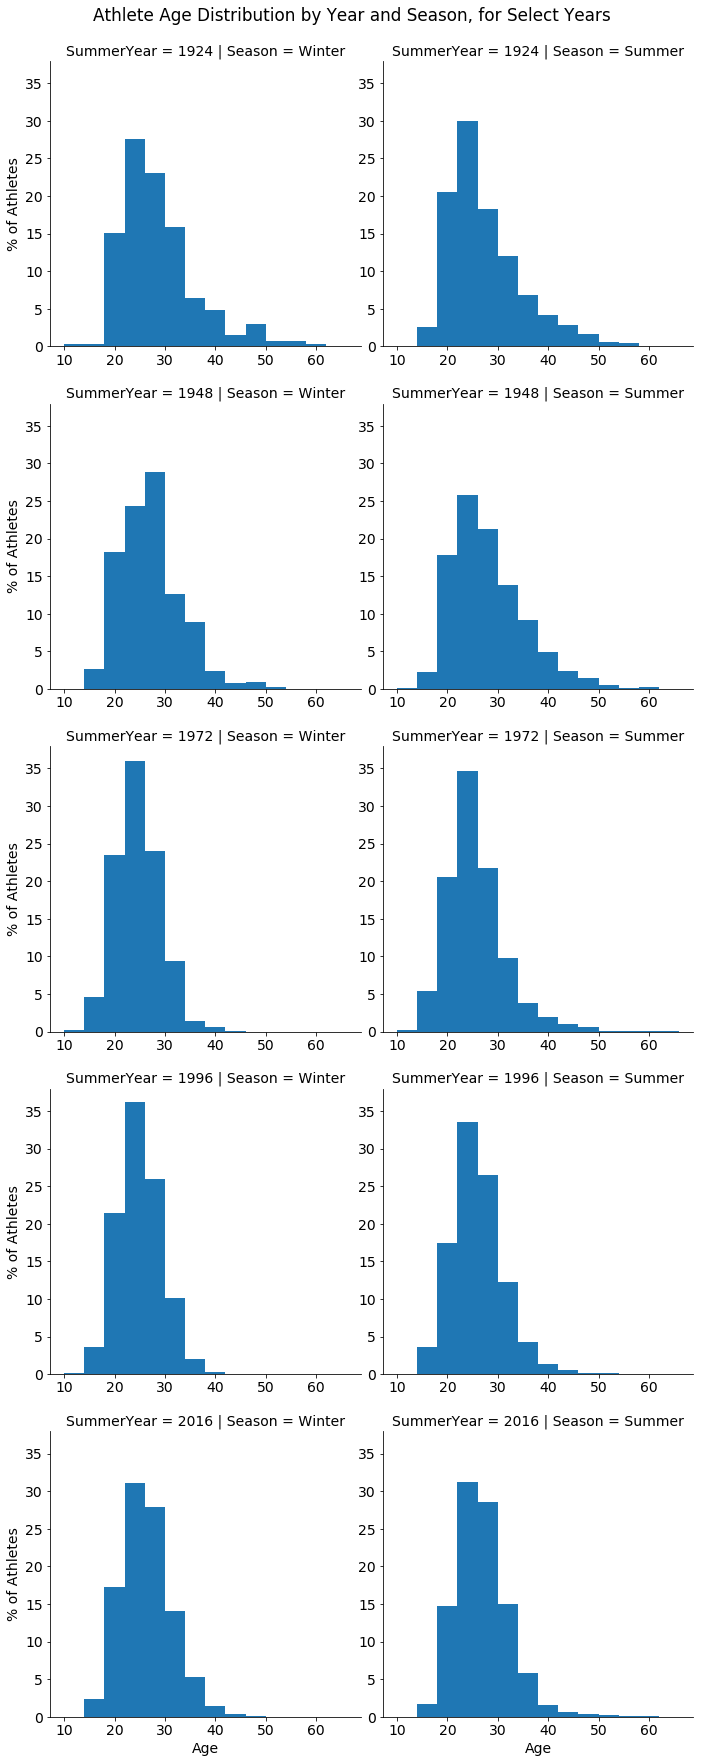

In [140]:
summer_years = [1924, 1948, 1972, 1996, 2016]
of_included_years = df_season_athletes_explore.SummerYear.isin(summer_years)
df_weights = (
    df_season_athletes_explore
    [of_included_years]
    .sort_values(['Season', 'SummerYear'])
)
df_weights['% of Athletes'] = get_weights_for_norm_hist(
    df_weights, ['Season', 'SummerYear']
)

g = sns.FacetGrid(
    data=df_weights,
    col='Season',
    row='SummerYear',
    height=5
)
g.map(weighted_hist, 'Age', '% of Athletes', bins=range(10, 70, 4));
repeat_facetgrid_ticklabels()
g.fig.subplots_adjust(top=0.95, hspace=0.2)
g.fig.suptitle('Athlete Age Distribution by Year and Season, for Select Years');

All of the distributions are right-tailed. Both seasons' distributions are pretty similar in the final row, but historically the Summer distributions are often more spread out, with lower peaks. Both seasons have seen a consolidation of higher percentages of athletes closer to the mean over the years. Finally, there is no recent trend of an increase in percentage of younger athletes visible here, for either Summer or Winter.

### Age, Year, Sport

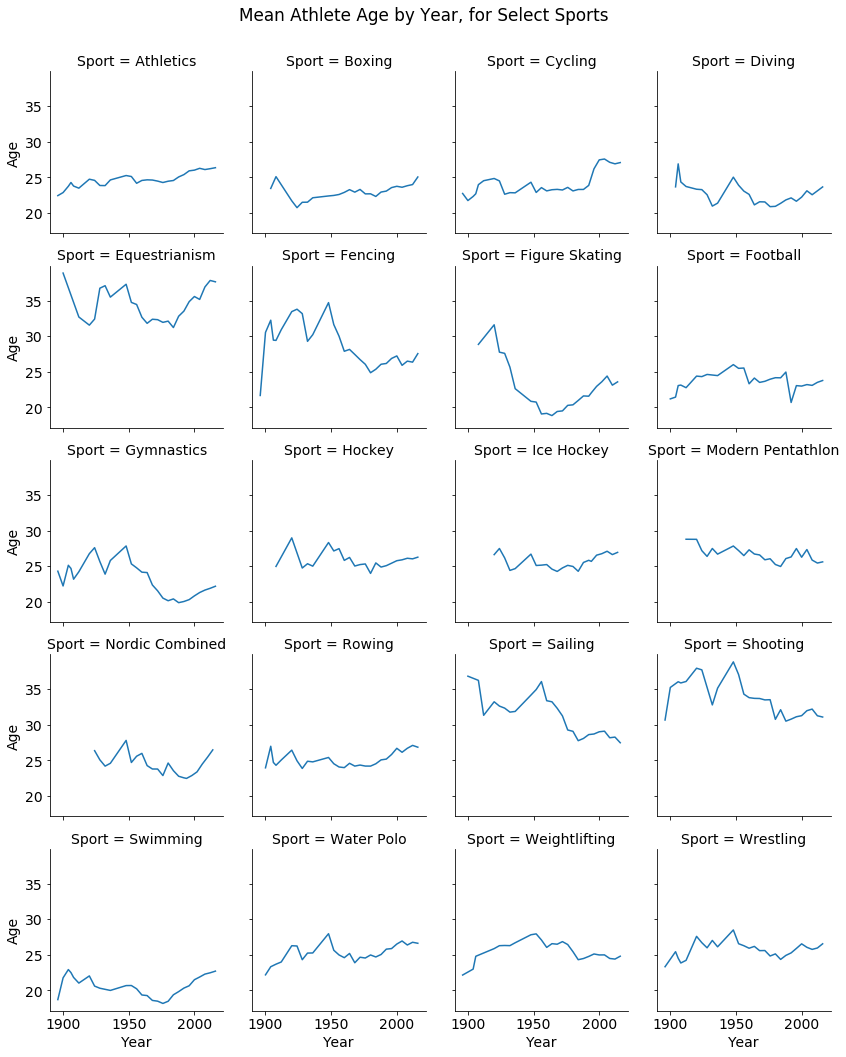

In [141]:
n_years_per_sport = (
    df_explore[['AthleteID', 'Year', 'Sport']]
    .drop_duplicates()
    .groupby(['Sport', 'Year'])
    .AthleteID.count().to_frame().reset_index()
    .groupby('Sport').Year.count().sort_values()
)
most_frequent_sports = sorted(n_years_per_sport.tail(20).index.tolist())
age_by_year_sport = (
    df_explore
    [df_explore.Sport.isin(most_frequent_sports)]
    .groupby(['Year', 'Sport'])
    .Age
    .mean()
    .to_frame()
    .reset_index()
)
g = sns.FacetGrid(
    data=age_by_year_sport,
    col='Sport',
    col_wrap=4,
    col_order=most_frequent_sports
)
g.map(plt.plot, 'Year', 'Age');
g.fig.subplots_adjust(top=0.92, hspace=0.2)
g.fig.suptitle('Mean Athlete Age by Year, for Select Sports');

Some observations:
* Athletics has a relatively stable linear change over time.
* Almost all of them have increasing age during the last ~25 years. Pentathlon, Sailing, Shooting, and Weightlifting are exceptions.
* Figure Skating has a very pronounced U shape. In fact, it appears to have the largest age drop, and it might have the largest age mean range over time (for this sample of Sports). Let's check. 

In [142]:
max_mean_age = age_by_year_sport.groupby('Sport').Age.max()
min_mean_age = age_by_year_sport.groupby('Sport').Age.min()
(max_mean_age - min_mean_age).sort_values(ascending=False)

Sport
Fencing              13.042049
Figure Skating       12.751684
Sailing               9.348474
Shooting              8.323567
Gymnastics            7.965744
Equestrianism         7.654059
Diving                6.009023
Cycling               5.835914
Weightlifting         5.781481
Water Polo            5.780665
Nordic Combined       5.337367
Football              5.316176
Wrestling             5.166667
Hockey                4.989132
Swimming              4.755929
Boxing                4.356250
Athletics             3.922075
Modern Pentathlon     3.824699
Rowing                3.238644
Ice Hockey            3.222359
Name: Age, dtype: float64

Fencing barely edges it out. The range in volatility among the sports is surprisingly large.

### Age, Year, Medal

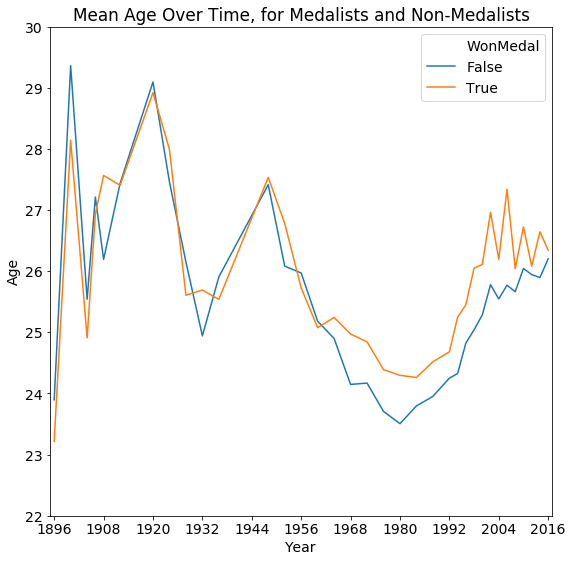

In [143]:
df_age_by_year_medal = (
    df_explore.groupby(['Year', 'WonMedal']).Age.mean().to_frame().reset_index()
)
plt.figure(figsize=default_figsize)
fig = sns.lineplot(
    data=df_age_by_year_medal, x='Year', y='Age', hue='WonMedal'
)
plt.title('Mean Age Over Time, for Medalists and Non-Medalists')
use_default_year_settings_for_x_axis()
plt.ylim(22, 30);

The age gap has generally been pretty small, but did start increasing around 1964. Let's redo the graph, except limited to only athletes who are new to the Olympics.

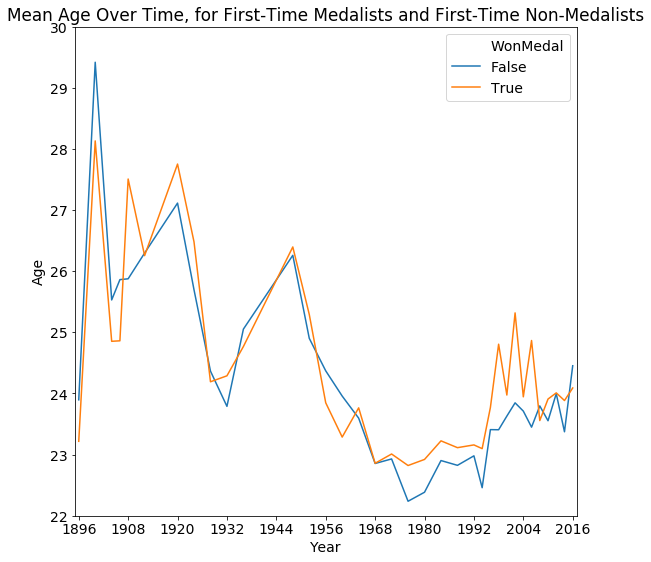

In [144]:
df_age_by_year_medal = (
    df_explore[df_explore.NPreviousSeasons == 0]
    .groupby(['Year', 'WonMedal']).Age.mean().to_frame().reset_index()
)
plt.figure(figsize=default_figsize)
fig = sns.lineplot(
    data=df_age_by_year_medal, x='Year', y='Age', hue='WonMedal'
)
plt.title(
    'Mean Age Over Time, for First-Time Medalists and First-Time Non-Medalists'
)
use_default_year_settings_for_x_axis()
plt.ylim(22, 30);

Slightly different. A smaller gap still emerges around 1974. Let's compare men and women on this issue.

### Age, Year, Sex, Medal

Let's create a new metric -- age gap between medalists and non-medalists -- to examine over time, for both men and women separately. We will exclude archers again.

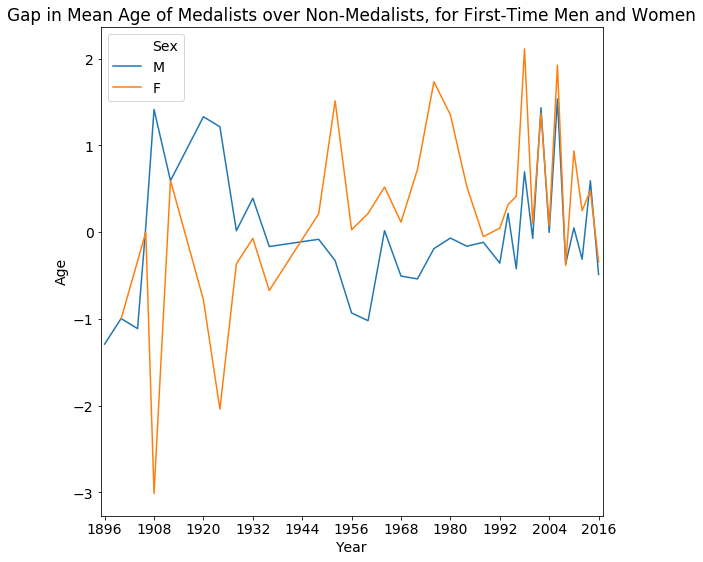

In [145]:
df_age_by_year_medal = (
    df_explore[
        (df_explore.NPreviousSeasons == 0)
    ]
    .groupby(['AthleteID', 'Year', 'WonMedal', 'Sex'])
    .Age.mean().to_frame().reset_index()
)
age_by_year_wonmedal = (
    df_age_by_year_medal[df_age_by_year_medal.WonMedal]
    .groupby(['Sex', 'Year']).Age.mean()
)
age_by_year_nomedal = (
    df_age_by_year_medal[~df_age_by_year_medal.WonMedal]
    .groupby(['Sex', 'Year']).Age.mean()
)
age_gap_by_sex = age_by_year_wonmedal - age_by_year_nomedal
df_age_gap_by_sex = age_gap_by_sex.to_frame().reset_index()

plt.figure(figsize=default_figsize)
fig = sns.lineplot(
    data=df_age_gap_by_sex, x='Year', y='Age', hue='Sex'
)
plt.title(
    'Gap in Mean Age of Medalists over Non-Medalists, ' +
    'for First-Time Men and Women'
)
use_default_year_settings_for_x_axis()

The age gap between first-time medalists and non-medalists tends to be more extreme for women than for men. Additionally, women used to fare better by being younger than the average; now they fare better by being older. The change occurred after World War II.

### Age, Year, Sex, Country

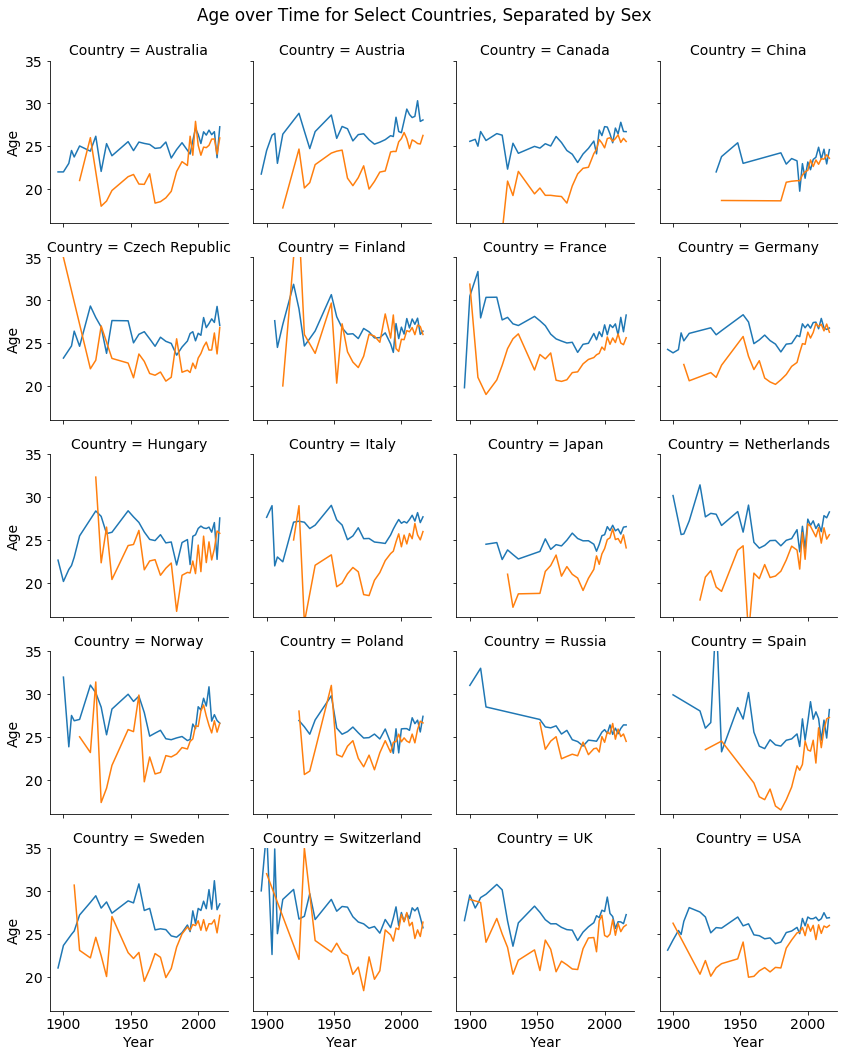

In [146]:
age_by_year_country_sex = (
    df_explore
    [df_explore.Country.isin(top_countries)]
    .groupby(['Year', 'Country', 'Sex'])
    .Age
    .mean()
    .to_frame()
    .reset_index()
)
g = sns.FacetGrid(
    data=age_by_year_country_sex,
    hue='Sex',
    hue_order=['M', 'F'],
    col='Country',
    col_wrap=4,
    col_order=sorted(top_countries)
)
plt.ylim(16, 35)
g.map(plt.plot, 'Year', 'Age');
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Age over Time for Select Countries, Separated by Sex');

A few countries (e.g., Germany) are actually starting to send male and female athletes with about the same mean age.

### Age, Year, Sex, Season

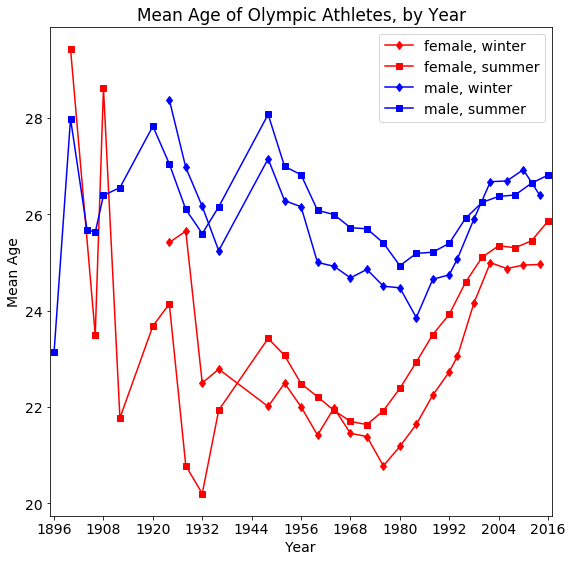

In [147]:
female = df_explore.IsFemale
male = ~df_explore.IsFemale
winter = df_explore.Season == 'Winter'
summer = df_explore.Season == 'Summer'

def age_mean_by_year(df):
    return remove_duplicate_athletes_by_year(df).groupby('Year').Age.mean()

female_winter_age_by_year = age_mean_by_year(df_explore[female & winter])
female_summer_age_by_year = age_mean_by_year(df_explore[female & summer])
male_winter_age_by_year = age_mean_by_year(df_explore[male & winter])
male_summer_age_by_year = age_mean_by_year(df_explore[male & summer])

plt.figure(figsize=default_figsize)
plt.plot(
    female_winter_age_by_year, color='r', label='female, winter', marker='d');
plt.plot(
    female_summer_age_by_year, color='r', label='female, summer', marker='s');
plt.plot(male_winter_age_by_year, color='b', label='male, winter', marker='d');
plt.plot(male_summer_age_by_year, color='b', label='male, summer', marker='s');
plt.legend()

labels_title('Year', 'Mean Age', 'Mean Age of Olympic Athletes, by Year')
use_default_year_settings_for_x_axis()

Winter athletes are usually younger than Summer athletes. The mean Summer age seems to be continuing an upward trend into the present, whereas the mean Winter age seems to be tapering off.

### Age, Year, Sex, Sport

Since female participation numbers were low in the early days, let's only use sports that have had female participation for a long time for this comparison.

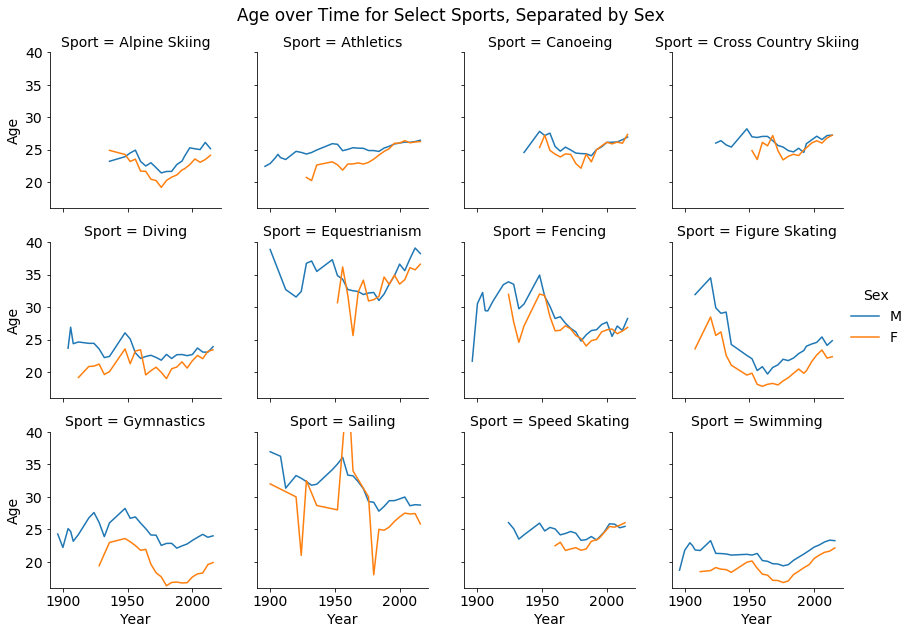

In [148]:
n_female_years_per_sport = (
    df_explore[df_explore.IsFemale]
    .groupby(['Sport', 'Year'])
    .AthleteID.count().to_frame().reset_index()
    .groupby('Sport').Year.count().sort_values()
)
most_freq_f_sports = sorted(n_female_years_per_sport.tail(12).index.tolist())
age_by_year_sport_sex = (
    df_explore
    [df_explore.Sport.isin(most_freq_f_sports)]
    .groupby(['Year', 'Sport', 'Sex'])
    .Age
    .mean()
    .to_frame()
    .reset_index()
)
g = sns.FacetGrid(
    data=age_by_year_sport_sex,
    hue='Sex',
    hue_order=['M', 'F'],
    col='Sport',
    col_wrap=4,
    col_order=most_freq_f_sports
)
plt.ylim(16, 40)
g.map(plt.plot, 'Year', 'Age');
g.fig.subplots_adjust(top=0.91)
g.fig.suptitle('Age over Time for Select Sports, Separated by Sex');
g.add_legend();

We can spot the familiar pattern in many of these sports of women's narrowing or closing the age gap with the men. Not so much with Gymnastics, however. It is interesting that Figure Skating maintains a consistent age gap between males and females, whereas Speed Skating appears to have closed it completely.

### Retirement Age by Year

In [149]:
df_explore = (
    df_explore
    .merge(df_athletes_explore[['BestMedal', 'NSeasons']], on='AthleteID')
)

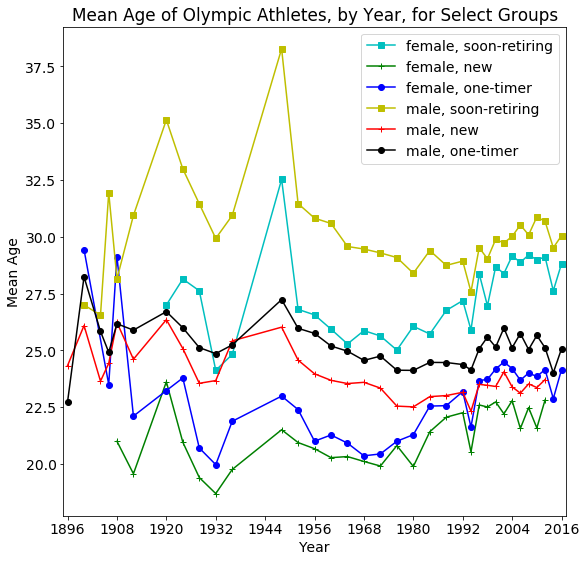

In [150]:
female = df_explore.IsFemale
male = ~df_explore.IsFemale
last_season = (df_explore.NSeasons == df_explore.NPreviousSeasons + 1)
multi_season = (df_explore.NSeasons > 1)
new = (df_explore.NPreviousSeasons == 0)

df_female_new = df_explore[female & multi_season & new]
df_female_onetime = df_explore[female & ~multi_season & new]
df_female_retiring = df_explore[female & last_season & multi_season]
df_male_new = df_explore[male & multi_season & new]
df_male_onetime = df_explore[male & ~multi_season & new]
df_male_retiring = df_explore[male & last_season & multi_season]

female_new_age_by_year = age_mean_by_year(df_female_new)
female_onetime_age_by_year = age_mean_by_year(df_female_onetime)
female_retiring_age_by_year = age_mean_by_year(df_female_retiring)
male_new_age_by_year = age_mean_by_year(df_male_new)
male_onetime_age_by_year = age_mean_by_year(df_male_onetime)
male_retiring_age_by_year = age_mean_by_year(df_male_retiring)

plt.figure(figsize=default_figsize)
plt.plot(female_retiring_age_by_year, color='c',
         label='female, soon-retiring', marker='s');
plt.plot(female_new_age_by_year, color='g', label='female, new', marker='+');
plt.plot(female_onetime_age_by_year, color='b',
         label='female, one-timer', marker='o');
plt.plot(male_retiring_age_by_year, color='y',
         label='male, soon-retiring', marker='s');
plt.plot(male_new_age_by_year, color='r', label='male, new', marker='+');
plt.plot(male_onetime_age_by_year, color='k',
         label='male, one-timer', marker='o');
plt.legend()

labels_title(
    'Year', 'Mean Age',
    'Mean Age of Olympic Athletes, by Year, for Select Groups'
)
use_default_year_settings_for_x_axis()


All groups have increased in age since ~1980. The "new" and "one-timer" groups within each sex tend to have fairly similar trends. Additionally, the graph is hard to read with so many different colors and symbols. Let's simplify the graph with just first-season athletes and last-season athletes, for each sex, and use the same color for a given sex and the same symbol for a given group on the other dimension.

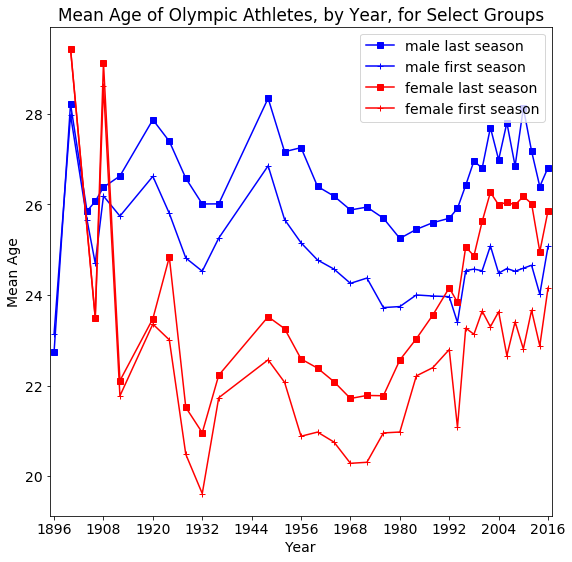

In [151]:
df_female_first = df_explore[female & new]
df_female_last = df_explore[female & last_season]
df_male_first = df_explore[male & new]
df_male_last = df_explore[male & last_season]

female_first_by_year = age_mean_by_year(df_explore[female & new])
female_last_by_year = age_mean_by_year(df_explore[female & last_season])
male_first_by_year = age_mean_by_year(df_explore[male & new])
male_last_by_year = age_mean_by_year(df_explore[male & last_season])

plt.figure(figsize=default_figsize)
plt.plot(male_last_by_year, color='b', label='male last season', marker='s');
plt.plot(male_first_by_year, color='b', label='male first season', marker='+');
plt.plot(female_last_by_year, color='r',
         label='female last season', marker='s');
plt.plot(female_first_by_year, color='r',
         label='female first season', marker='+');
plt.legend()

labels_title(
    'Year', 'Mean Age',
    'Mean Age of Olympic Athletes, by Year, for Select Groups'
)
use_default_year_settings_for_x_axis()

Probably the most interesting feature of the graph is the huge increase in last-season female athletes' mean age from 1976 to 2002.

# Save Data Frames

In [152]:
# We'll use these in the explanatory phase.
df_explore.to_csv('df_explore.csv')
df_athletes_explore.to_csv('df_athletes_explore.csv')
df_season_athletes_explore.to_csv('df_season_athletes_explore.csv')

In [153]:
pd.read_csv('df_explore.csv', index_col=0).head()

,AthleteID,Sex,Age,Country,Year,Season,Sport,Event,Medal,NPreviousSeasons,IsTeamEvent,IsFemale,HasPrevExp,WonMedal,SummerYear,BestMedal,NSeasons
0,35698,M,22,Australia,1896,Summer,Athletics,Athletics Men's 800 metres,Gold,0,False,False,False,True,1896,Gold,1
1,35698,M,22,Australia,1896,Summer,Athletics,"Athletics Men's 1,500 metres",Gold,0,False,False,False,True,1896,Gold,1
2,35698,M,22,Australia,1896,Summer,Athletics,Athletics Men's Marathon,None,0,False,False,False,False,1896,Gold,1
3,35698,M,22,Australia,1896,Summer,Tennis,Tennis Men's Singles,None,0,False,False,False,False,1896,Gold,1
4,35698,M,22,Australia,1896,Summer,Tennis,Tennis Men's Doubles,Bronze,0,True,False,False,True,1896,Gold,1


In [154]:
pd.read_csv('df_athletes_explore.csv', index_col=0).head()

,Sex,BestMedal,NSeasons
AthleteID,,,
1,M,None,1
10,M,None,1
100,M,Bronze,1
1000,M,Bronze,1
10000,M,None,1


In [155]:
pd.read_csv('df_season_athletes_explore.csv', index_col=0).head()

,AthleteID,Sex,Age,Country,Year,Season,NPreviousSeasons,IsFemale,SummerYear
0,35698,M,22,Australia,1896,Summer,0,False,1896
3,107090,M,34,Denmark,1896,Summer,0,False,1896
4,54456,M,21,Denmark,1896,Summer,0,False,1896
6,85988,M,29,Denmark,1896,Summer,0,False,1896
7,122526,M,19,France,1896,Summer,0,False,1896
